In [1]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

import os
import xarray as xr
import cftime
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
# import xesmf as xe
from pathlib import Path
import glob
from data_locations import LOC_FORECASTS_SI, LOC_OBSERVATIONS_SI
from preprocessing import align_data_and_targets, create_mask
from preprocessing import AnomaliesScaler_v1, Standardizer, PreprocessingPipeline
from torch_datasets import XArrayDataset
import numpy as np
from numpy import meshgrid, deg2rad, gradient, sin, cos
from xarray import DataArray
import xarray as xr


In [2]:
NPSProj = False

In [3]:
data_dir_forecast = LOC_FORECASTS_SI
if NPSProj:
    data_dir_obs = glob.glob(LOC_OBSERVATIONS_SI+ '/NASA*NPS*.nc')[0]
else:
    data_dir_obs = glob.glob(LOC_OBSERVATIONS_SI+ '/NASA*1x1*.nc')[0]  


In [4]:
print("Start training")
print("Load observations")

obs_in = xr.open_dataset(data_dir_obs)['SICN']


print("Load forecasts") 
if NPSProj:
    ls = [xr.open_dataset(glob.glob(LOC_FORECASTS_SI + f'/*_initial_month_{lead_month}_*NPS*.nc')[0])['SICN'].mean('ensembles') for lead_month in range(1,13) ]
    ds_in = xr.concat(ls, dim = 'time').sortby('time')   
else:
    ls = [xr.open_dataset(glob.glob(LOC_FORECASTS_SI + f'/*_initial_month_{lead_month}_*1x1*.nc')[0])['SICN'].mean('ensembles') for lead_month in range(1,13) ]
    ds_in = xr.concat(ls, dim = 'time').sortby('time')
    ds_in = ds_in.where(ds_in<1000,np.nan)


land_mask = obs_in.mean('time').where(np.isnan(obs_in.mean('time')),1).fillna(0)
model_mask = ds_in.mean('time')[0].where(np.isnan(ds_in.mean('time')[0]),1).fillna(0).drop('lead_time')


obs_in = obs_in.clip(0,1)
ds_in = ds_in.clip(0,1)
obs_in = obs_in.fillna(0)
ds_in = ds_in.fillna(0)

if NPSProj:
    mask_projection = (xr.open_dataset(data_dir_obs)['mask'].rename({'x':'lon','y':'lat'}))
    obs_in = (obs_in.rename({'x':'lon','y':'lat'}))
    ds_in = (ds_in.rename({'x':'lon','y':'lat'}))
    land_mask = (land_mask.rename({'x':'lon','y':'lat'}))
    mask_projection = mask_projection.isel(lat=slice(None, None, -1))
    obs_in = obs_in.isel(lat=slice(None, None, -1))
    ds_in = ds_in.isel(lat=slice(None, None, -1))
    land_mask = land_mask.isel(lat=slice(None, None, -1))


Start training
Load observations
Load forecasts


In [5]:
if not NPSProj:
    ds_in = ds_in.where(ds_in.lat > 40, drop = True)
    obs_in = obs_in.where(obs_in.lat > 40, drop = True)
    model_mask = model_mask.where(model_mask.lat > 40, drop = True)
    land_mask = land_mask.where(land_mask.lat > 40, drop = True)
    model_mask = model_mask.where(model_mask.lat > 40, drop = True)
    # land_mask = land_mask.where(model_mask == 1, 0)
ds_in = ds_in * land_mask
obs_in = obs_in * land_mask


In [6]:


def smoother(ds, smoother_kernel = 10):
    from scipy.ndimage import convolve
    kernel_lat = np.ones(( smoother_kernel, 1)) / smoother_kernel
    # Apply the moving average filter in latitude using convolution
    smoothed_data_lat = convolve(ds, kernel_lat, mode='constant')
    # Create the filter kernel for longitude
    kernel_lon = np.ones(( 1, smoother_kernel)) / smoother_kernel
    # Apply the moving average filter in longitude using convolution
    smoothed_data_lon = convolve(smoothed_data_lat, kernel_lon, mode='constant')
    # Print the smoothed data in latitude and longitude
    return smoothed_data_lon

def zeros_mask_gen(obs, smoother_kernel = 10):
    ls = [obs[np.arange(0,len(obs),12)+i,...].max('time').squeeze() for i in range(12)]
    ls = [ds.where(ds>0, 0) for ds in ls]
    ls = [ds.where(ds==0, 1) for ds in ls]
    for ind, ds in enumerate(ls):
        ls[ind][:] = smoother(ds, smoother_kernel)
    ls = [ds.where(ds>0, 0) for ds in ls]
    ls = [ds.where(ds==0, 1) for ds in ls]
    active_mask = xr.concat(ls, dim = 'month').assign_coords(month = np.arange(1,13)).to_dataset(name = 'active_mask')
    
    ls = [obs[np.arange(0,len(obs),12)+i,...].min('time').squeeze() for i in range(12)]
    ls = [ds.where(ds>=0.90, 0) for ds in ls]
    ls = [ds.where(ds==0, 1) for ds in ls]
    full_ice_mask = xr.concat(ls, dim = 'month').assign_coords(month = np.arange(1,13)).to_dataset(name = 'full_ice_mask')

    return xr.combine_by_coords([active_mask, full_ice_mask])



In [15]:
# zeros_mask_full2 = zeros_mask_gen(obs_in)

In [4]:
# weights = np.cos(np.ones_like(obs_in.lon) * (np.deg2rad(obs_in.lat.to_numpy()))[..., None])  # Moved this up
# weights = xr.DataArray(weights, dims = ds_in.dims[-2:], name = 'weights').assign_coords({'lat': obs_in.lat, 'lon' : obs_in.lon}) 
# ds_in_p = ds_in - ((ds_in * weights).sum(['lat','lon'])/weights.sum(['lat','lon']))
# ((ds_in_p * weights).sum(['lat','lon'])/weights.sum(['lat','lon']))[:,1].plot()

# Script Check

In [5]:

obs_in = obs_in.expand_dims('channels', axis=1)

if 'ensembles' in ds_in.dims: ### PG: add channels dimention to the correct axis based on whether we have ensembles or not
    ds_in = ds_in.expand_dims('channels', axis=3)
else:
    ds_in = ds_in.expand_dims('channels', axis=2) 

ds_raw, obs_raw = align_data_and_targets(ds_in, obs_in, 12)

if not ds_raw.time.equals(obs_raw.time):
        
        ds_raw = ds_raw.sel(time = obs_raw.time)

In [6]:
del ds_raw

In [6]:
if 'ensembles' in ds_raw.dims: ## PG: reorder dimensions in you have ensembles
    ds_raw_ensemble_mean = ds_raw.transpose('time','lead_time','ensembles',...)
else:
    ds_raw_ensemble_mean = ds_raw.transpose('time','lead_time',...)


In [7]:
ds_raw_ensemble_mean = ds_raw_ensemble_mean.where(ds_raw_ensemble_mean.lat > 40, drop = True)
obs_raw = obs_raw.where(obs_raw.lat > 40, drop = True)
land_mask = land_mask.where(land_mask.lat > 40, drop = True)

In [8]:
from preprocessing import pole_centric
ds_raw_ensemble_mean = pole_centric(ds_raw_ensemble_mean, 'North')
obs_raw =  pole_centric(obs_raw, 'North')
land_mask =  pole_centric(land_mask, 'North')

In [26]:
weights = np.cos(np.ones_like(ds_raw_ensemble_mean.lon) * (np.deg2rad(ds_raw_ensemble_mean.lat.to_numpy()))[..., None])  # Moved this up
weights = xr.DataArray(weights, dims = ds_raw_ensemble_mean.dims[-2:], name = 'weights').assign_coords({'lat': ds_raw_ensemble_mean.lat, 'lon' : ds_raw_ensemble_mean.lon}) 
weights = weights * land_mask
# ds_raw_mean = ((ds_raw_ensemble_mean * weights).sum(['lat','lon'])/weights.sum(['lat','lon']))
# obs_raw_mean = ((obs_raw * weights).sum(['lat','lon'])/weights.sum(['lat','lon']))
# ds_raw_ensemble_mean = ds_raw_ensemble_mean - ((ds_raw_ensemble_mean * weights).sum(['lat','lon'])/weights.sum(['lat','lon']))
# obs_raw = obs_raw  - ((obs_raw * weights).sum(['lat','lon'])/weights.sum(['lat','lon']))

# from preprocessing import calculate_climatology, bias_adj
# def global_mean_bias_adj(year):
    
#     train_years = ds_raw_ensemble_mean.time[ds_raw_ensemble_mean.time < year * 100].to_numpy()
#     n_train = len(train_years)
#     train_mask = create_mask(ds_raw_ensemble_mean[:n_train,...])
#     ds_baseline_mean = ds_raw_mean[:n_train,...]
#     obs_baseline_mean = obs_raw_mean[:n_train,...]
#     fct_clim = calculate_climatology(ds_baseline_mean.where(~np.broadcast_to(train_mask[...,None], ds_baseline_mean.shape)))
#     obs_clim = calculate_climatology(obs_baseline_mean.where(~np.broadcast_to(train_mask[...,None], ds_baseline_mean.shape)))
#     fct_bias_adjusted = bias_adj(ds_raw_mean[n_train:n_train + 12,...] , fct_clim , obs_clim)
#     return fct_bias_adjusted

# fct_global_bias_adj = xr.concat([global_mean_bias_adj(year) for year in range(2006,2021)], dim = 'time')

NameError: name 'ds_raw_ensemble_mean' is not defined

In [41]:
fct_global_bias_adj[np.arange(0,180,12) + 8,1].plot()
ds_raw_mean.sel(time = fct_global_bias_adj.time)[np.arange(0,180,12) + 8,1].plot()
obs_raw_mean.sel(time = fct_global_bias_adj.time)[np.arange(0,180,12) + 8,1].plot()

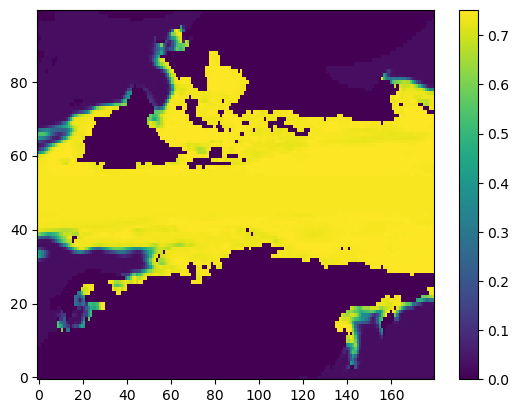

In [29]:
plt.pcolor(np.arange(180), np.arange(100),(obs[0,0,0] * land_mask).values)
plt.colorbar()

In [19]:
test_year = 2018
train_years = ds_raw_ensemble_mean.time[ds_raw_ensemble_mean.time < test_year * 100].to_numpy()

n_train = len(train_years)
train_mask = create_mask(ds_raw_ensemble_mean[:n_train,...])

ds_baseline = ds_raw_ensemble_mean[:n_train,...]
obs_baseline = obs_raw[:n_train,...]


In [20]:
from preprocessing import AnomaliesScaler_v1_seasonal, AnomaliesScaler_v2_seasonal, Normalizer
preprocessing_mask_fct = np.broadcast_to(train_mask[...,None,None,None], ds_baseline.shape)
preprocessing_mask_obs = np.broadcast_to(train_mask[...,None,None,None], obs_baseline.shape)

forecast_preprocessing_steps = [
        ('normalizer', Normalizer())]

observations_preprocessing_steps = [
        ('normalizer', Normalizer())]



In [57]:
if 'anomalies' in [item[0] for item in forecast_preprocessing_steps]:
    sigmoid_activation = False
else:
    sigmoid_activation = True

sigmoid_activation

True

In [21]:
ds_pipeline = PreprocessingPipeline(forecast_preprocessing_steps).fit(ds_baseline, mask=preprocessing_mask_fct)
ds = ds_pipeline.transform(ds_raw_ensemble_mean)

In [26]:
obs_pipeline = PreprocessingPipeline(observations_preprocessing_steps).fit(obs_baseline, mask=preprocessing_mask_obs)
obs = obs_pipeline.transform(obs_raw)


In [61]:

def calculate_climatology(ds, mask = None):
    if mask is not None:
        ds = ds.where(~mask)
    return xr.concat([ds.isel(time = np.arange(0,len(ds.time),12) + init_month).mean('time') for init_month in range(12) ], dim = 'init_month').assign_coords(init_month = np.arange(1,13))

In [32]:

ds_train = ds[:n_train,...]
obs_train = obs[:n_train,...]
ds_test = ds[n_train:n_train + 12,...]
obs_test = obs[n_train:n_train + 12,...]

In [ ]:
weights = np.cos(np.ones_like(ds_train.lon) * np.flip(np.deg2rad(ds_train.lat.to_numpy()))[..., None])  # Moved this up
weights = xr.DataArray(weights, dims = ds_train.dims[-2:], name = 'weights').assign_coords({'lat': ds_train.lat, 'lon' : ds_train.lon}) # Create an DataArray to pass to Spatialnanremove() 
weights_ = weights.copy()

In [ ]:
ds_train = ds_train.stack(ref = ['lat','lon']) # PG: flatten and sample training data at those locations
obs_train = obs_train.stack(ref = ['lat','lon']) ## PG: flatten and sample obs data at those locations
weights = weights.stack(ref = ['lat','lon']) ## PG: flatten and sample weighs at those locations
weights_ = weights_.stack(ref = ['lat','lon'])
weights = weights.values
weights_ = weights_.values
img_dim = ds_train.shape[-1] ## PG: The input dim is now the length of the flattened dimention.


In [ ]:
train_set = XArrayDataset(ds_train, obs_train, mask=train_mask, in_memory=False, lead_time=None, time_features=['month_sin', 'month_cos'],ensemble_features =None, aligned = True, year_max = year_max) 


# Test

In [7]:
from module_FINAL_global_avg import earth_radius, area_grid
from module_FINAL_plotting_maps import plot_single_map_wmo
import matplotlib as mpl
import cartopy.crs as ccrs
import matplotlib.transforms as transforms
from preprocessing import Detrender

def detrending(ds, reference = None, remove_intercept = False, version = 1):
     ref_lead_time = False
     if reference is None:
          reference = ds
     if 'lead_time' in reference.dims:
          version = version
     else:
          version = None


     time = ds['time']
     detrender = Detrender(trend_dim='time', deg=1, version = version)
     detrender.fit(reference) 
     out = detrender.transform(ds,  remove_intercept=remove_intercept)
     out['time'] = time
     return out
     

def ice_extent(ds, Pole = 'North', NPSProj = False):

     area = area_grid(obs_in.lat, obs_in.lon) 
     if NPSProj:
          area = xr.ones_like(area) * 26450**2 * land_mask
          pole = None
     else:
          area = area * land_mask
     
    
     if Pole == 'North':
          ds = ds.where(ds.lat > 40, drop = True)
          area = area.where(area.lat > 40, drop = True)
     else:
          ds = ds.where(ds.lat < -40, drop = True)
          area = area.where(area.lat < -40, drop = True)

     area = xr.ones_like(ds) * area
     out =  area.where(ds >= 0.15,0).sum(['lat','lon'])/1e12
     out = out.where(out>0, np.nan)

     return out


def ice_area(ds, Pole = 'North', NPSProj = False):

     area = area_grid(obs_in.lat, obs_in.lon) 
     if NPSProj:
          area = xr.ones_like(area) * 26450**2 * land_mask
          pole = None
     else:
          area = area * land_mask

     if Pole == 'North':
        ds = ds.where(ds.lat > 40, drop = True)
        area = area.where(area.lat > 40, drop = True)
     else:
        ds = ds.where(ds.lat < -40, drop = True)
        area = area.where(area.lat < -40, drop = True)

     out =  (ds * area).sum(['lat','lon'])/1e12
     out = out.where(out>0, np.nan)

     return out

def IIEE(ds1,ds2, NPSProj = False):

     
     d1 = xr.ones_like(ds1)
     d1 = d1.where(ds1 >= 0.15 , 0)
     d1 = d1.where(~np.isnan(ds1))

     d2 = xr.ones_like(ds2)
     d2 = d2.where(ds2 >= 0.15 , 0)
     d2 = d2.where(~np.isnan(ds2))

     area = area_grid(obs_in.lat, obs_in.lon) 
     if NPSProj:
          area = xr.ones_like(area) * 26450**2 * land_mask
     else:
          area = area * land_mask
     return (np.abs(d1 - d2) * area).sum(['lat','lon'])/1e12
 

def rmse_full(d1,d2):
     #  area = area_grid(d1.lat, d1.lon)
      #  return (np.abs(d1 - d2) * area).sum(['lat','lon'])/area.sum(['lat','lon'])
      return np.sqrt(((d1 - d2)**2).mean())

def corr_map(ds1, ds2):
     #    mean1 = ds1.mean(['lat','lon'])
     #    mean2 = ds2.mean(['lat','lon'])
     #    std1 = ds1.std(['lat','lon'])
     #    std2 = ds2.std(['lat','lon'])
     #    covariance = ((ds1 - mean1) * (ds2 - mean2)).mean(['lat','lon'])
     #    return (covariance / (std1 * std2))
     se1 = np.sqrt((ds1**2).mean(['lat','lon']))
     se2 = np.sqrt((ds2**2).mean(['lat','lon']))
     return (ds1 * ds2).mean(['lat','lon']) / (se1 * se2)

def rmse(ds1,ds2):
     return np.sqrt(((ds1 - ds2)**2).mean('time'))

def pole_finder(ds, pole = 'North'):
     if  pole == 'North':
          return ds.where(ds.lat>40, drop = True)
     elif pole == 'South':
          return ds.where(ds.lat<-40, drop = True)
     else:
          return ds
     
def extract_tragte_month(ds, lead_time = 12,target_month = 3):      
    ls = [ds.sel(lead_time = lead_month + 1 ).where(np.mod(np.mod(ds.sel(lead_time = lead_month + 1 ).time,100) + lead_month,12) == np.mod(target_month,12), drop = True) for lead_month in range(lead_time)]
    for ind, ds in enumerate(ls):
        (added_year, month) = np.divmod(np.mod(ds.time,100) + ind,12)
        if target_month == 12 :
             added_year = 0
             month = 12
        ds['time'] = (ds.time/100 + added_year).astype(int)*100 + month
        ls[ind] = ds
    return xr.concat(ls, dim = 'lead_time').transpose('time','lead_time',...)

def call_to_plot(months_to_plot, adj_data_list = ['Deb', 'Det', 'NN'] ,Antarctic = False, show_polar_stereo = True, central_longitude= 0 , show_SIE = False, fig_name = None, fig_dir = None, save  =False, NPSProj = False):

          if Antarctic:
               lat_lims = [-90,-40]
               pole = 'South'
          else:
               lat_lims = [40,90]
               pole = 'North'

          if show_polar_stereo:
               crs = ccrs.NorthPolarStereo()    
               if max(lat_lims) < 0:
                    crs = ccrs.SouthPolarStereo()   
          else:
               crs = ccrs.PlateCarree(central_longitude=central_longitude)

          fig, ax = plt.subplots(nrows=months_to_plot ,
                           ncols=len(adj_data_list) + 2, 
                           figsize=(25,10*months_to_plot), 
                           subplot_kw={'projection' : crs}) 

          if months_to_plot == 1:
               ax = ax[None, :]
          
          figure = 'FigX'
          vmin  = 0
          vmax  = 1
          
          if show_SIE:
               varx = 'SIE'
               units = 'm$^2$'
          cmap_var = mpl.cm.Blues
          if NPSProj:
               pole = None
          
          for lead_time in range(months_to_plot):
               
               axis = ax[lead_time, 0]
               axis.text(-0.5,1.1, f'lead_month: {lead_time + 1}',  fontsize=15, transform=axis.transAxes)

               data = model.sel(lead_time = lead_time + 1 )
               data = data.where(~np.isnan(data), drop = True)
               ref = observation.sel(time = data.time.values)

               iiee = IIEE(pole_finder(data, pole), pole_finder(ref, pole), NPSProj = NPSProj).mean('time').values
               corr = corr_map(pole_finder(data, pole), pole_finder(ref, pole)).mean('time').values
               rmse_ = rmse_full(pole_finder(data, pole), pole_finder(ref, pole)).values

               if lead_time ==  0:
                    label = f'CanCM4 \n corr : {str(np.round(corr,2))}, rmse = {str(np.round(rmse_,2))}, IIEE : {str(np.round(iiee,2))} million Km^2'
               else:
                    label = f'corr : {str(np.round(corr,2))}, rmse = {str(np.round(rmse_,2))}, IIEE : {str(np.round(iiee,2))} million Km^2'

               plot_single_map_wmo(fig, ax[lead_time, 0] , data.mean('time') , title = label, cbar = False, vmin=vmin, ds_sig=None,
                        vmax=vmax,polar_stereo=show_polar_stereo, central_longitude=central_longitude,   lat_lims=lat_lims, cmap=cmap_var, NPSProj = NPSProj)
               
               count = 0
               if 'Deb' in adj_data_list:
                    count = count + 1
                    corr = corr_map( pole_finder(bias_adj.sel(time = data.time.values).isel(lead_time = lead_time), pole), pole_finder(ref, pole)).mean('time').values
                    iiee = IIEE( pole_finder(bias_adj.sel(time = data.time.values).isel(lead_time = lead_time), pole), pole_finder(ref, pole), NPSProj = NPSProj).mean('time').values
                    rmse_ = rmse_full( pole_finder(bias_adj.sel(time = data.time.values).isel(lead_time = lead_time), pole), pole_finder(ref, pole)).values

                    if lead_time ==  0:
                         label = f'bias_adj \n corr : {str(np.round(corr,2))}, rmse = {str(np.round(rmse_,2))}, IIEE : {str(np.round(iiee,2))} million Km^2'
                    else:
                         label = f'corr : {str(np.round(corr,2))}, rmse = {str(np.round(rmse_,2))}, IIEE : {str(np.round(iiee,2))} million Km^2'

                    plot_single_map_wmo(fig, ax[lead_time, count] ,  bias_adj.sel(time = data.time.values).isel(lead_time = lead_time).mean('time'), title = label, cbar = False, vmin=vmin,ds_sig=None,
                         vmax=vmax,polar_stereo=show_polar_stereo, central_longitude=central_longitude,    lat_lims=lat_lims, cmap=cmap_var, NPSProj = NPSProj)

               if 'Deb' in adj_data_list:
                    count = count + 1
                    corr = corr_map( pole_finder(trend_adj.sel(time = data.time.values).isel(lead_time = lead_time), pole), pole_finder(ref, pole)).mean('time').values
                    iiee = IIEE( pole_finder(trend_adj.sel(time = data.time.values).isel(lead_time = lead_time), pole), pole_finder(ref, pole), NPSProj = NPSProj).mean('time').values
                    rmse_ = rmse_full( pole_finder(trend_adj.sel(time = data.time.values).isel(lead_time = lead_time), pole), pole_finder(ref, pole)).values
          
                    if lead_time ==  0:
                         label = f'Trend_adj \n corr : {str(np.round(corr,2))}, rmse = {str(np.round(rmse_,2))}, IIEE : {str(np.round(iiee,2))} million Km^2'
                    else:
                         label = f' corr : {str(np.round(corr,2))}, rmse = {str(np.round(rmse_,2))}, IIEE : {str(np.round(iiee,2))} million Km^2'

                    plot_single_map_wmo(fig, ax[lead_time, count] ,  trend_adj.sel(time = data.time.values).isel(lead_time = lead_time).mean('time'), title = label, cbar = False, vmin=vmin,ds_sig=None,
                         vmax=vmax,polar_stereo=show_polar_stereo, central_longitude=central_longitude,    lat_lims=lat_lims, cmap=cmap_var, NPSProj = NPSProj)
               
               if 'NN' in adj_data_list:
                    count = count + 1
                    corr = corr_map(pole_finder(adj.sel(time = data.time.values).isel(lead_time = lead_time), pole), pole_finder(ref, pole)).mean('time').values
                    iiee = IIEE(pole_finder(adj.sel(time = data.time.values).isel(lead_time = lead_time), pole), pole_finder(ref, pole), NPSProj = NPSProj).mean('time').values
                    rmse_ = rmse_full(pole_finder(adj.sel(time = data.time.values).isel(lead_time = lead_time), pole), pole_finder(ref, pole)).values
                    
                    if lead_time ==  0:
                         label = f'nn_adj \n corr : {str(np.round(corr,2))}, rmse = {str(np.round(rmse_,2))}, IIEE : {str(np.round(iiee,2))} million Km^2'
                    else:
                         label = f'corr : {str(np.round(corr,2))}, rmse = {str(np.round(rmse_,2))}, IIEE : {str(np.round(iiee,2))} million Km^2'
                    
                    plot_single_map_wmo(fig, ax[lead_time, count] ,  adj.sel(time = data.time.values).isel(lead_time = lead_time).mean('time'), title = label, cbar = False, vmin=vmin,ds_sig=None,
                         vmax=vmax,polar_stereo=show_polar_stereo, central_longitude=central_longitude,    lat_lims=lat_lims, cmap=cmap_var, NPSProj = NPSProj)

               

               if lead_time == months_to_plot -1 :
                    cbar = True
               else:
                    cbar = False
               corr = corr_map(pole_finder(ref, pole), pole_finder(observation.sel(time = data.time.values), pole)).mean('time').values   

               if lead_time ==  0:
                    label = f'obs \n ({str(np.round(corr,2))})'
               else:
                    label = f'({str(np.round(corr,2))})'
               
               plot_single_map_wmo(fig, ax[lead_time, -1] ,  observation.sel(time = data.time.values).mean('time'), title = label, cbar = cbar, vmin=vmin,ds_sig=None,
                        vmax=vmax,polar_stereo=show_polar_stereo, central_longitude=central_longitude,    lat_lims=lat_lims, cmap=cmap_var, NPSProj = NPSProj)
               

               
               if save:
                    Path(fig_dir).mkdir(parents=True, exist_ok=True)
                    plt.savefig(fig_dir+'/'+fig_name,
                    bbox_inches='tight',
                    dpi=300)

        


def ice_extent_plot(target_month, lead_months,  adj_data_list : list ,pole = 'North', metric = 'RMSE', detrend=False, remove_intercept = False, NPSProj = False):


    colors = ['b','r','g','c','m','purple']
    labels = {'Deb': 'bias adjusted', 'Det': 'trend adjusted', 'NN' : 'NN adjusted'}


    adj_dict = {}
    for key in adj_data_list:
          adj_dict[key] = extract_tragte_month( data_dicts[key], lead_months, target_month)

    
    model = extract_tragte_month(ds_model, lead_months, target_month)
    observation = obs.sel(time = model.time)

    plt.figure(figsize = (8,8 * len(adj_data_list)))
    
    time = adj_dict[adj_data_list[0]].time
    ref = ice_extent(observation.sel(time = time), pole, NPSProj = NPSProj)
    CanESM5 = ice_extent(model.sel(time = time), pole, NPSProj = NPSProj)

    if detrend:
     #     trend_ref = ref.copy()

         CanESM5 = detrending(CanESM5,  remove_intercept = remove_intercept)
         ref = detrending(ref,  remove_intercept = remove_intercept)

    for ind, key in enumerate(adj_data_list):

        data_to_plot = ice_extent(adj_dict[key].sel(time = time), pole, NPSProj = NPSProj)
        if detrend:
               data_to_plot = detrending(data_to_plot, remove_intercept = remove_intercept)

        plt.subplot(len(adj_data_list),1,ind+1)
        ref.plot(linewidth = 2, color = 'k')
        for lead_month in range(1,lead_months + 1):
            if metric == 'RMSE':
               corr = rmse(CanESM5.sel(lead_time = lead_month) ,ref ).values
            else:
                corr = xr.corr(CanESM5.sel(lead_time = lead_month) ,ref , dim = 'time' ).values 
               

            CanESM5.sel(lead_time = lead_month).plot(color = colors[lead_month-1], linestyle = 'dashed', label = f'CanCM4 lead month {lead_month} {metric}: ({str(np.round(corr,2))})')

            if metric == 'RMSE':
               corr = rmse(ref,data_to_plot.sel(lead_time = lead_month)).values
            else:
                 corr = xr.corr(ref,data_to_plot.sel(lead_time = lead_month) , dim = 'time' ).values

            data_to_plot.sel(lead_time = lead_month).plot(color = colors[lead_month-1], label = f'{labels[key]} lead month {lead_month} {metric}: ({str(np.round(corr,2))})')
        
        if ind == 0:
               plt.title(pole + ' SIE')
        else:
               plt.title('')

        plt.ylabel('million km$^2$')
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

        plt.xticks(time.values,rotation = 45)
        
def ice_area_plot(target_month, lead_months,  adj_data_list : list ,pole = 'North', metric = 'RMSE', detrend=False, remove_intercept = False, NPSProj = False):


    colors = ['b','r','g','c','m','purple']
    labels = {'Deb': 'bias adjusted', 'Det': 'trend adjusted', 'NN' : 'NN adjusted'}


    adj_dict = {}
    for key in adj_data_list:
          adj_dict[key] = extract_tragte_month( data_dicts[key], lead_months, target_month)

    
    model = extract_tragte_month(ds_model, lead_months, target_month)
    observation = obs.sel(time = model.time)

    plt.figure(figsize = (8,8 * len(adj_data_list)))
    
    time = adj_dict[adj_data_list[0]].time
    ref = ice_area(observation.sel(time = time), pole, NPSProj = NPSProj)
    CanESM5 = ice_area(model.sel(time = time), pole, NPSProj = NPSProj)


    if detrend:
     #     trend_ref = ref.copy()

         CanESM5 = detrending(CanESM5,  remove_intercept = remove_intercept)
         ref = detrending(ref,remove_intercept = remove_intercept)
         

    for ind, key in enumerate(adj_data_list):

        data_to_plot = ice_area(adj_dict[key].sel(time = time), pole, NPSProj = NPSProj)
        if detrend:
               data_to_plot = detrending(data_to_plot,  remove_intercept = remove_intercept)

        plt.subplot(len(adj_data_list),1,ind+1)
        ref.plot(linewidth = 2, color = 'k')
        for lead_month in range(1,lead_months + 1):
            if metric == 'RMSE':
               corr = rmse(CanESM5.sel(lead_time = lead_month) ,ref ).values
            else:
                corr = xr.corr(CanESM5.sel(lead_time = lead_month) ,ref , dim = 'time' ).values 
               

            CanESM5.sel(lead_time = lead_month).plot(color = colors[lead_month-1], linestyle = 'dashed', label = f'CanCM4 lead month {lead_month} {metric}: ({str(np.round(corr,2))})')

            if metric == 'RMSE':
               corr = rmse(ref,data_to_plot.sel(lead_time = lead_month)).values
            else:
                 corr = xr.corr(ref,data_to_plot.sel(lead_time = lead_month) , dim = 'time' ).values

            data_to_plot.sel(lead_time = lead_month).plot(color = colors[lead_month-1], label = f'{labels[key]} lead month {lead_month} {metric}: ({str(np.round(corr,2))})')
        
        if ind == 0:
               plt.title(pole + ' SI Area')
        else:
               plt.title('')

        plt.ylabel('million km$^2$')
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

        plt.xticks(time.values,rotation = 45)       


import matplotlib.transforms as transforms
import pandas as pd
import seaborn as sns

def heat_map_data(ds, metric= 'RMSE', lead_times = 12, pole = 'North', mode = 'ice_extent', detrend = False, remove_intercept = False, NPSProj = False):
    ls = []
    
    if NPSProj:
          pole = None
    for target_month in range(12):
        ds_ = extract_tragte_month(ds,lead_times,target_month+1)
        ref = obs.sel(time = ds_.time)
        
        if mode == 'IIEE':
               iiee_list = []
               ref = pole_finder(ref, pole)
               ds_ = pole_finder(ds_, pole)
               for lt in range(lead_times):
                    d1 = ds_.isel(lead_time = lt)                  
                    d1 = d1.where(~np.isnan(d1), drop = True)
                    iiee_list.append(IIEE(d1, ref.sel(time = d1.time), NPSProj = NPSProj))

               ls.append(xr.concat(iiee_list , dim = 'lead_time').assign_coords(lead_time = ds_.lead_time))
               metric = 'IIEE'
        elif mode == 'grid_wise':
               d_ref = pole_finder(ref, pole)
               d_plot = pole_finder(ds_, pole)
               area = area_grid(d_ref.lat, d_ref.lon) 
               if NPSProj:
                    area = xr.ones_like(area) * 26450**2 * land_mask
               else:
                    area = area * land_mask

               if detrend:
               # trend_ref = d_ref.copy()

                    d_plot = detrending(d_plot,  remove_intercept = remove_intercept )
                    d_ref = detrending(d_ref, remove_intercept = remove_intercept )       

               if metric == 'RMSE':
                    met = rmse(d_ref, d_plot)
               else:
                    met = xr.corr(d_ref, d_plot, dim = 'time')

               ls.append((met * area).sum(['lat','lon'])/area.sum(['lat','lon']))

        else:

          if mode == 'ice_extent':
               d_ref = ice_extent(ref, pole, NPSProj = NPSProj)
               d_plot = ice_extent(ds_, pole, NPSProj = NPSProj)

          elif mode == 'ice_area':
               d_ref = ice_area(ref, pole, NPSProj = NPSProj)
               d_plot = ice_area(ds_, pole, NPSProj = NPSProj)
               
          if detrend:
               # trend_ref = d_ref.copy()

               d_plot = detrending(d_plot,  remove_intercept = remove_intercept )
               d_ref = detrending(d_ref, remove_intercept = remove_intercept )

          if metric == 'RMSE':
               ls.append(rmse(d_ref, d_plot))
          else:
               ls.append(xr.corr(d_ref, d_plot, dim = 'time'))
         
    return xr.concat( ls , dim = 'target_month').assign_coords(target_month = np.arange(1,13)).squeeze().to_dataset(name = metric)



def plot_heat_maps(adj_data_list:list ,lead_times = 12, metric= 'RMSE', pole = 'North', mode = "ice_extent", detrend = False,remove_intercept = False, NPSProj = False):
    if mode == 'grid_wise': 
          vmax = 0.1
          vmin = 0
    else:
          vmax = 1.5
          vmin = 0
    labels = {'Deb': 'bias adjusted', 'Det': 'trend adjusted', 'NN' : 'NN adjusted', 'Raw' : 'Raw'}

    plt.figure(figsize = (10 * len(adj_data_list),8))
    cmap = 'inferno'
    if metric == 'Corr':
        vmax = 1
        vmin = 0
        cmap = 'inferno_r'

     

    for ind, name in enumerate(adj_data_list):
        ax = plt.subplot(1,len(adj_data_list),ind + 1 )
        dataframe = heat_map_data(data_dicts[name],lead_times = lead_times, metric = metric, pole = pole, mode = mode, detrend = detrend, remove_intercept = remove_intercept, NPSProj = NPSProj).to_dataframe().reset_index().pivot(index='target_month', columns=f'lead_time')[metric]

        ax = sns.heatmap(dataframe, annot=True,  cmap = cmap ,linewidth=.5, vmax = vmax , vmin = vmin)
        plt.yticks(rotation = 0)
     #    plt.yticks(ticks = np.arange(1,13) - 0.5, labels = ['Jan','Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec' ],rotation=0)
        if detrend:
          plt.text(0.01,1.05, f'{labels[name]} {mode} detrended test {metric} ', transform=ax.transAxes)
        else:
          plt.text(0.01,1.05, f'{labels[name]} {mode} test {metric}', transform=ax.transAxes)




def plot_IIEE_heat_maps(adj_data_list:list ,lead_times = 12,  pole = 'North', NPSProj = False):

    vmax = 2.5
    vmin = 0.5

    labels = {'Deb': 'bias adjusted', 'Det': 'trend adjusted', 'NN' : 'NN adjusted', 'Raw' : 'Raw'}

    plt.figure(figsize = (10 * len(adj_data_list),8))
    cmap = 'inferno'

    for ind, name in enumerate(adj_data_list):
        ax = plt.subplot(1,len(adj_data_list),ind + 1 )
        dataframe = heat_map_data(data_dicts[name], lead_times = lead_times , pole = pole, mode = 'IIEE', NPSProj =NPSProj ).mean('time').to_dataframe().reset_index().pivot(index='target_month', columns=f'lead_time')['IIEE']

        ax = sns.heatmap(dataframe, annot=True,  cmap = cmap ,linewidth=.5, vmax = vmax , vmin = vmin)
        plt.yticks(rotation = 0)
        plt.yticks(ticks = np.arange(1,13) - 0.5, labels = ['Jan','Feb', 'Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec' ],rotation=0)

        plt.text(0.01,1.05, f'{labels[name]} IIEE test', transform=ax.transAxes)

### Obs_test

In [8]:
ds = xr.open_dataset('/space/hall5/sitestore/eccc/crd/ccrn/users/rms101/SCRIPTS/ifd_fud/DATA/IN_DAILY_SIC_OBS/MERGED/seaice_conc_daily_nh_cdr_seaice_conc_198101_202112_nrt_202201_filled_1_1x1.nc')

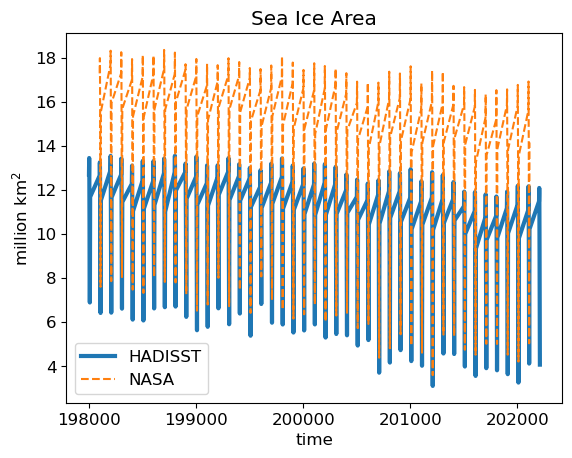

In [31]:
hadisst = xr.open_dataset('/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/data/SI/observation/uws_hadisst2.2_cis_great_cmc_1x1_198001_202209_sicn.nc')['SICN']
nasa = xr.open_dataset('/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/data/SI/observation/NASA_team_bootstrap_1x1_198101_202112_sicn.nc')['SICN']

ice_area(hadisst, 'North').plot(label = 'HADISST', linewidth = 3)
ice_area(nasa, 'North').plot(label = 'NASA', linestyle = 'dashed')
plt.ylabel('million km$^2$')
plt.title('Sea Ice Area')
plt.legend()

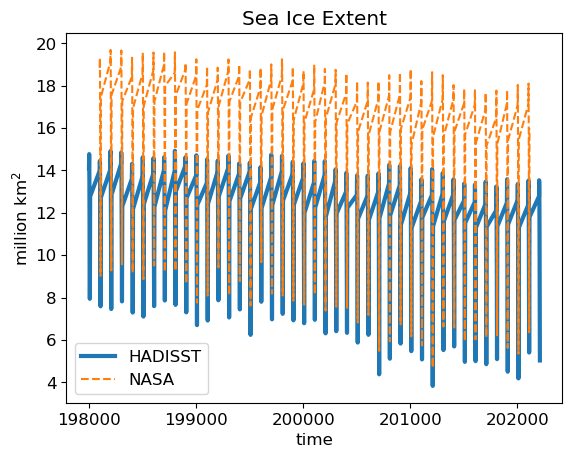

In [33]:
ice_extent(hadisst, 'North').plot(label = 'HADISST', linewidth = 3)
ice_extent(nasa, 'North').plot(label = 'NASA', linestyle = 'dashed')
plt.ylabel('million km$^2$')
plt.title('Sea Ice Extent')
plt.legend()


### Load bias/trend adjusted

In [11]:
obs_source = 'NASA'

In [14]:
out_dir = f'/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/output/SI/Full/results/{obs_source}'
if NPSProj:
    deb = xr.open_dataset(out_dir + '/Bias_Adjusted/bias_adjusted_North_2006-2020_NPSproj.nc')['SICN'].clip(0,1)
else:
    deb = xr.open_dataset(out_dir + '/Bias_Adjusted/bias_adjusted_North_2006-2020_1x1.nc')['SICN'].clip(0,1)

det = xr.open_dataset(out_dir + '/Trend_Adjusted/trend_adjusted_North_2006-2020.nc')['SICN'].clip(0,1)


## North

In [ ]:
# out_dir = f'/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/output/SI/Full/results/NASA/UNet/run_set_1/N15_M12_vIceExtent_North_batch100_e60_LNone'
# nn = xr.open_mfdataset(str(Path(out_dir, "*.nc")), combine= 'nested', concat_dim='time')['nn_adjusted'].squeeze().clip(0,1)

In [15]:
model = 'UNetLSTM'
run_set = 8

results = ['N15_LT6_F12_v1_1x1_lr_scheduler_North_lr0.001_batch10_e30_LNone_new']
# results = ['N15_LT1_F12_v1_North_lr0.001_batch10_e70_LNone', 'N15_LT2_F12_v1_North_lr0.001_batch10_e65_LNone', 'N15_LT3_F12_v1_North_lr0.001_batch10_e70_LNone',
#           'N15_LT4_F12_v1_1x1_North_lr0.001_batch10_e70_LNone', 'N15_LT5_F12_v1_1x1_North_lr0.001_batch10_e70_LNone' ]

ls = []
for link in results:
    out_dir = f'/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/output/SI/Full/results/{obs_source}/{model}/run_set_{run_set}/{link}'
    ls.append(xr.open_mfdataset(str(Path(out_dir, "*.nc")), combine= 'nested', concat_dim='time')['nn_adjusted'].squeeze())
nn = xr.concat(ls, dim = 'lead_time')
    
try:
    nn = nn.drop('init_month')
except:
    pass
nn = nn.clip(0,1) #* land_mask
# 
ds_model = ds_in.sel(time = nn.time)
obs = xr.open_dataset(data_dir_obs)['SICN'].clip(0,1).fillna(0)
if NPSProj:
    obs = (obs.rename({'x':'lon','y':'lat'}))
    obs = obs.isel(lat=slice(None, None, -1))
    nn = nn.isel(lat=slice(None, None, -1))

data_dicts = { 'Deb' : deb, 'Det' : det, 'NN' :nn, 'Raw' : ds_model }
# data_dicts = { 'Deb' : deb.where(deb.time > 201000, drop = True), 'Det' : det.where(det.time > 201000, drop = True), 'NN' :nn.where(nn.time > 201000, drop = True), 'Raw' : ds_model.where(ds_model.time > 201000, drop = True) }


In [31]:
# nn = nn.where(nn>= 0.10, 0)
# data_dicts['NN'] = nn

##### Ice Extent version

In [16]:
deb = deb.where(deb>=0.15,0)
deb = deb.where(deb ==0 , 1)

det = det.where(det>=0.15,0)
det = det.where(det ==0 , 1)

ds_model = ds_model.where(ds_model>=0.15,0)
ds_model = ds_model.where(ds_model ==0 , 1)

obs = obs.where(obs>=0.15,0)
obs = obs.where(obs ==0 , 1)

data_dicts = { 'Deb' : deb, 'Det' : det, 'NN' :nn, 'Raw' : ds_model }

##### Monthly CNNLSTM

In [27]:
dir = '/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/output/SI/Full/results/NASA/UNetLSTM_monthly/run_set_1/'

nn = xr.concat([xr.open_dataset(dir + f'N15_M{i}_v2_lr_scheduler_North_lr0.001_batch10_e60_LNone/nn_adjusted_lead_month_{i}_1.nc' ) for i in range(2,7)], dim = 'lead_time')['nn_adjusted'].squeeze().clip(0,1)
nn = xr.concat([deb.isel(lead_time = 0),nn], dim = 'lead_time')
data_dicts['NN'] = nn

##### Multiply by active grid cells if available

In [34]:
## Multiply by the active grid cells
active_grid = xr.open_mfdataset(str(Path(out_dir, "*.nc")), combine= 'nested', concat_dim='time')['active_grid']
active_grid = active_grid.where(active_grid == 0 , 1)
nn = nn * active_grid
data_dicts['NN'] = nn

##### Replace the global mean with that of the bias adjusted

In [60]:
## Replace the global mean
nn = nn.squeeze()
weights = np.cos(np.ones_like(nn.lon) * (np.deg2rad(nn.lat.to_numpy()))[..., None])  # Moved this up
weights = xr.DataArray(weights, dims = nn.dims[-2:], name = 'weights').assign_coords({'lat': nn.lat, 'lon' : nn.lon}) 

nn  =nn - ((nn * weights).sum(['lat','lon'])/weights.sum(['lat','lon'])) + (deb* weights).sum(['lat','lon'])/weights.sum(['lat','lon'])
nn = nn.clip(0,1)

data_dicts['NN'] = nn


#### Figures

In [283]:
# def sorted_x_y_ind(x):

#     x_sort_ind = np.zeros_like(x)
#     x_sorted = np.zeros_like(x)
#     for row in range((x.shape[0])):
#         x_sort_ind[row,:] = np.argsort(x[row,:])
#         x_sorted[row,:] = np.sort(x[row,:])

#     # y= np.transpose(y)
#     # y_sort_ind = np.zeros_like(y)
#     # y_sorted = np.zeros_like(y)
#     # for row in range((y.shape[0])):
#     #     y_sort_ind[row,:] = np.argsort(y[row,:])
#     #     y_sorted[row,:] = np.sort(y[row,:])
        
#     return x_sorted, x_sort_ind.astype('int')#, np.transpose(y_sorted), np.transpose(y_sort_ind).astype('int')

# def sort_by_ind(ds, ind_x):
#     return np.concatenate([ds[..., row,:][..., ind_x[row,:]][...,None,:] for row in range(ind_x.shape[0])] , axis = -2 )


# def latlon_to_xy(ds, pole = 'North'):
#     target_crs = 'epsg:3995'
#     if pole == 'South':
#         target_crs = 'epsg:3031' # Coordinate system of the file
    
#     source_crs = 'epsg:4326' # Global lat-lon coordinate system
#     X, Y = np.meshgrid( ds.lon.values, ds.lat.values)
#     latlon_to_polar = pyproj.Transformer.from_crs(source_crs, target_crs)
#     boxx, boxy = latlon_to_polar.transform(Y, X)

#     trans_shape = ds.transpose(..., 'lon', 'lat').shape

#     # boxx_sorted, boxx_sorted_ind , boxy_sorted, boxy_sorted_ind =  sorted_x_y_ind(boxx, boxy)
#     # out = sort_by_ind(ds.values, boxx_sorted_ind )
#     # out = sort_by_ind(out.reshape(trans_shape), np.transpose(boxy_sorted_ind) ).reshape(ds.shape)

#     boxx_sorted, boxx_sorted_ind=  sorted_x_y_ind(boxx)
#     out = sort_by_ind(ds.values, boxx_sorted_ind )
#     boxy = sort_by_ind(boxy, boxx_sorted_ind )

#     boxy_sorted, boxy_sorted_ind =  sorted_x_y_ind(np.transpose(boxy))
#     out = sort_by_ind(out.reshape(trans_shape), boxy_sorted_ind ).reshape(ds.shape)


#     out = xr.DataArray(out, dims = ds.rename({'lat':'y', 'lon':'x'}).dims ,coords=dict(
#         x_dist=([ "y","x"], boxx_sorted),
#         y_dist=(["y","x"], np.transpose(boxy_sorted)))).assign_coords(ds.drop(['lat','lon']).coords)
    
#     return out

In [20]:
data_dicts['NN']

<xarray.DataArray 'nn_adjusted' (lead_time: 1, time: 180, lat: 50, lon: 360)>
dask.array<clip, shape=(1, 180, 50, 360), dtype=float64, chunksize=(1, 12, 50, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 40.5 41.5 42.5 43.5 44.5 ... 86.5 87.5 88.5 89.5
  * lead_time  (lead_time) int64 6
  * time       (time) float64 2.006e+05 2.006e+05 ... 2.02e+05 2.02e+05

In [18]:
lead_months = 12
target_month  = 5 
adj_data_list = ['Deb','Det', 'NN']
# adj_data_list = ['NN']

adj = extract_tragte_month(nn,lead_months,target_month)
bias_adj = extract_tragte_month(deb,lead_months,target_month)
trend_adj = extract_tragte_month(det,lead_months,target_month)
model = extract_tragte_month(ds_model,lead_months,target_month)
observation = obs.sel(time = adj.time)

call_to_plot(months_to_plot = lead_months, adj_data_list = adj_data_list,  Antarctic= False, NPSProj  = NPSProj)

KeyError: "not all values found in index 'lead_time'. Try setting the `method` keyword argument (example: method='nearest')."

In [47]:


# model = extract_tragte_month(ds_model, lead_months, target_month)
# observation = obs.sel(time = model.time)

# plt.figure(figsize = (8,6 ))
    
# time = model.time
# ref = ice_extent(observation.sel(time = time), 'North')
# CanESM5 = ice_extent(model.sel(time = time), 'North')
# colors = ['b','r','g','c','m','purple']

# ref.plot(linewidth = 2, color = 'k')

# for lead_month in range(1,3 + 1):

#             RMSE = rmse(CanESM5.sel(lead_time = lead_month) ,ref ).values
#             corr = xr.corr(CanESM5.sel(lead_time = lead_month) ,ref , 'time').values

#             CanESM5.sel(lead_time = lead_month).plot(color = colors[lead_month-1], linestyle = 'dashed', label = f'CanCM4 lead month {lead_month} RMSE: ({str(np.round(RMSE,2))}) Corr: ({str(np.round(corr,2))})')



# plt.ylabel('million km$^2$')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# plt.xticks(time.values,rotation = 45)
# plt.title('Arctic SIE')

In [ ]:
lead_months = 3
target_month = 3

weights = np.cos(np.ones_like(nn.lon) * (np.deg2rad(nn.lat.to_numpy()))[..., None])  # Moved this up
weights = xr.DataArray(weights, dims = nn.dims[-2:], name = 'weights').assign_coords({'lat': nn.lat, 'lon' : nn.lon}) 
weights = weights * land_mask
o = ((extract_tragte_month(obs_raw,lead_months,target_month) * weights).sum(['lat','lon'])/weights.sum(['lat','lon']))[-15:,]
n = xr.open_mfdataset(str(Path(out_dir, "*.nc")), combine= 'nested', concat_dim='time')['nn_adjusted'].squeeze()#.clip(0,1)
n = n - xr.open_mfdataset(str(Path(out_dir, "*.nc")), combine= 'nested', concat_dim='time')['bias_adjusted'].squeeze()
n = ((extract_tragte_month(n,lead_months,target_month) * weights).sum(['lat','lon'])/weights.sum(['lat','lon']))

for i in range(6):
    # o[:,i].plot(linewidth = 2, color  = 'k')
    n[:,i].plot(label = f'nn PatternsOnly lead month {i+1}')
plt.legend()

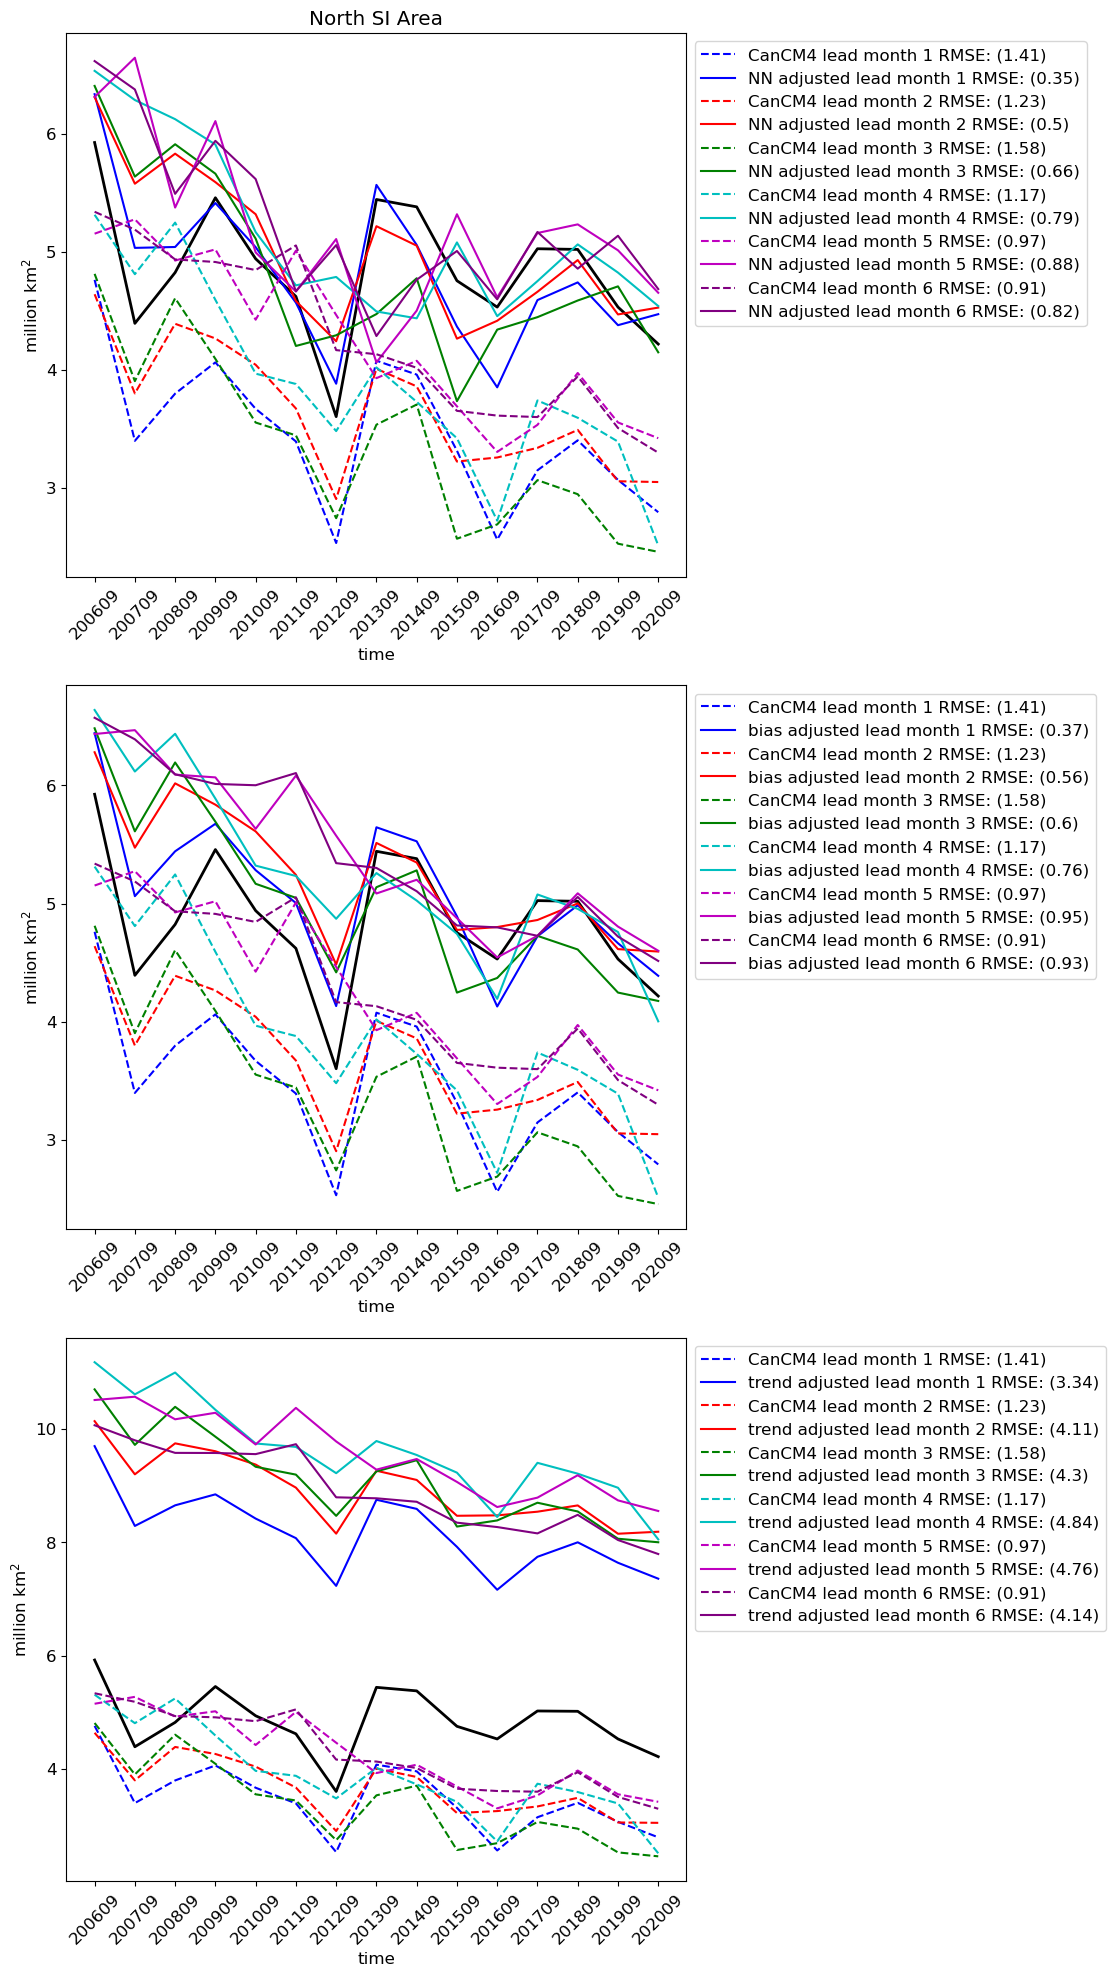

In [11]:
lead_months = 6
target_month = 9
adj_data_list =['NN','Deb','Det']
ice_area_plot(target_month , lead_months, adj_data_list, 'North', NPSProj=NPSProj)



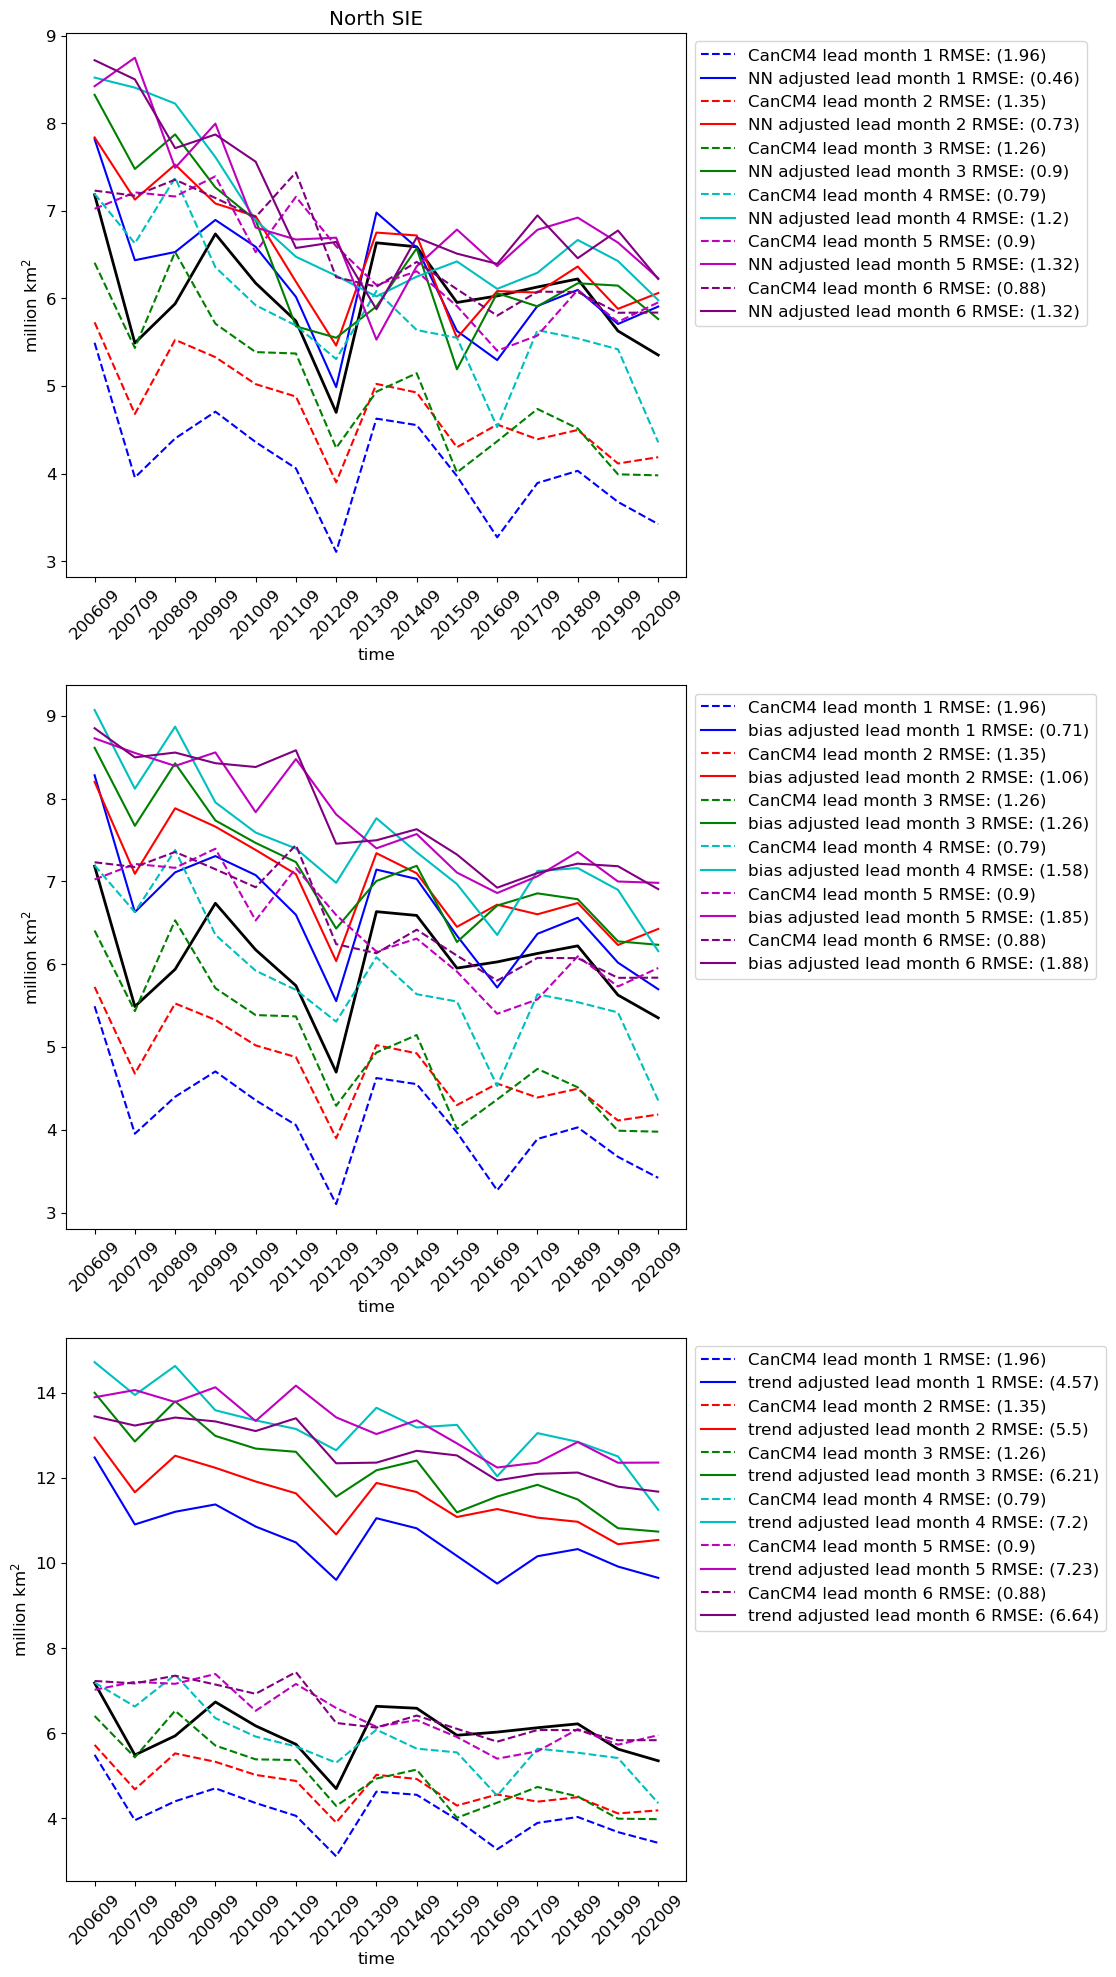

In [12]:

ice_extent_plot(target_month , lead_months,adj_data_list, 'North', metric='RMSE', NPSProj=NPSProj)



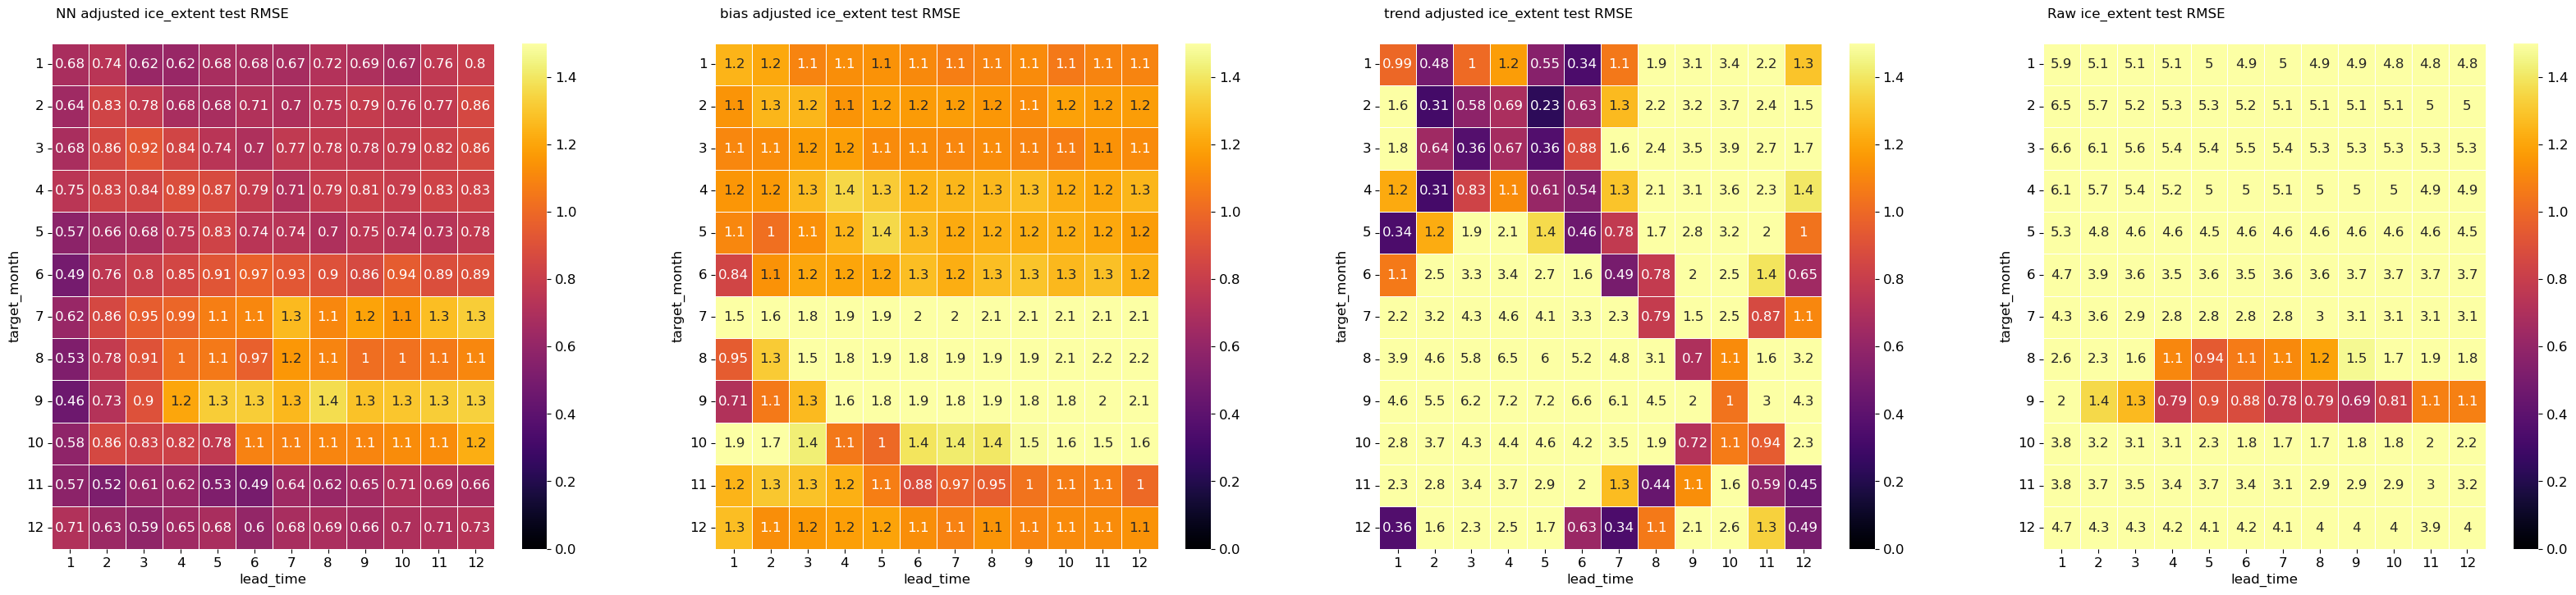

In [15]:
METRIC = 'RMSE'
lead_times = 12
adj_data_list = ['NN','Deb','Det','Raw']
plot_heat_maps(adj_data_list, lead_times = lead_times, metric = METRIC, NPSProj=NPSProj)



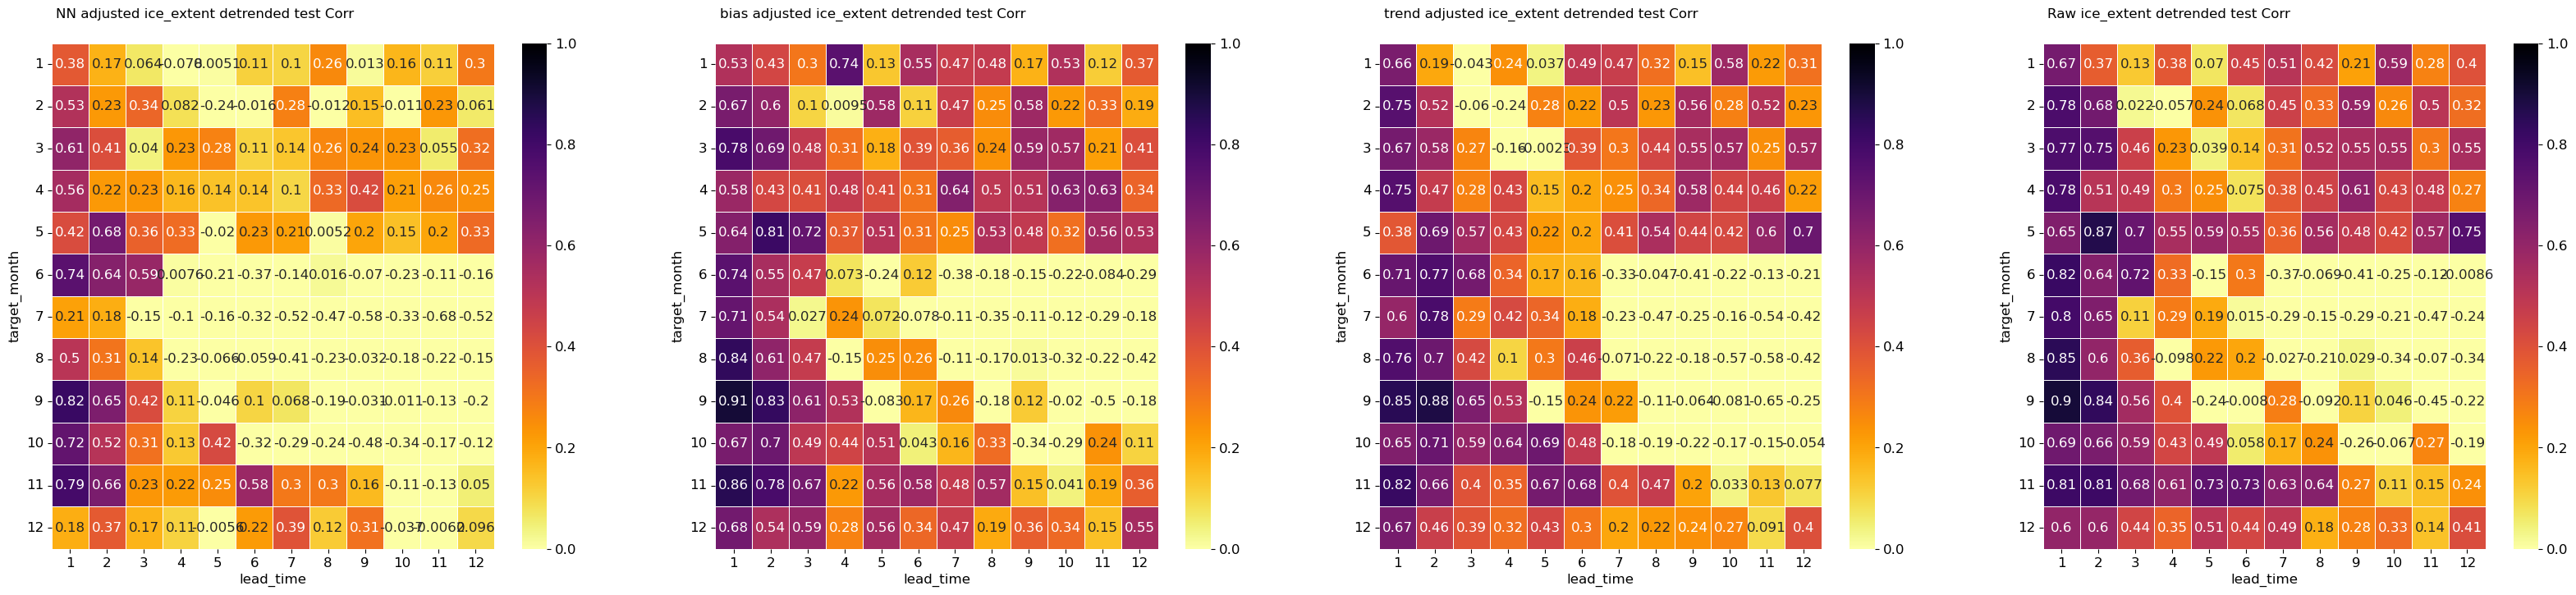

In [16]:
METRIC = 'Corr'

plot_heat_maps(adj_data_list, lead_times = lead_times, metric = METRIC, detrend=True, NPSProj=NPSProj)

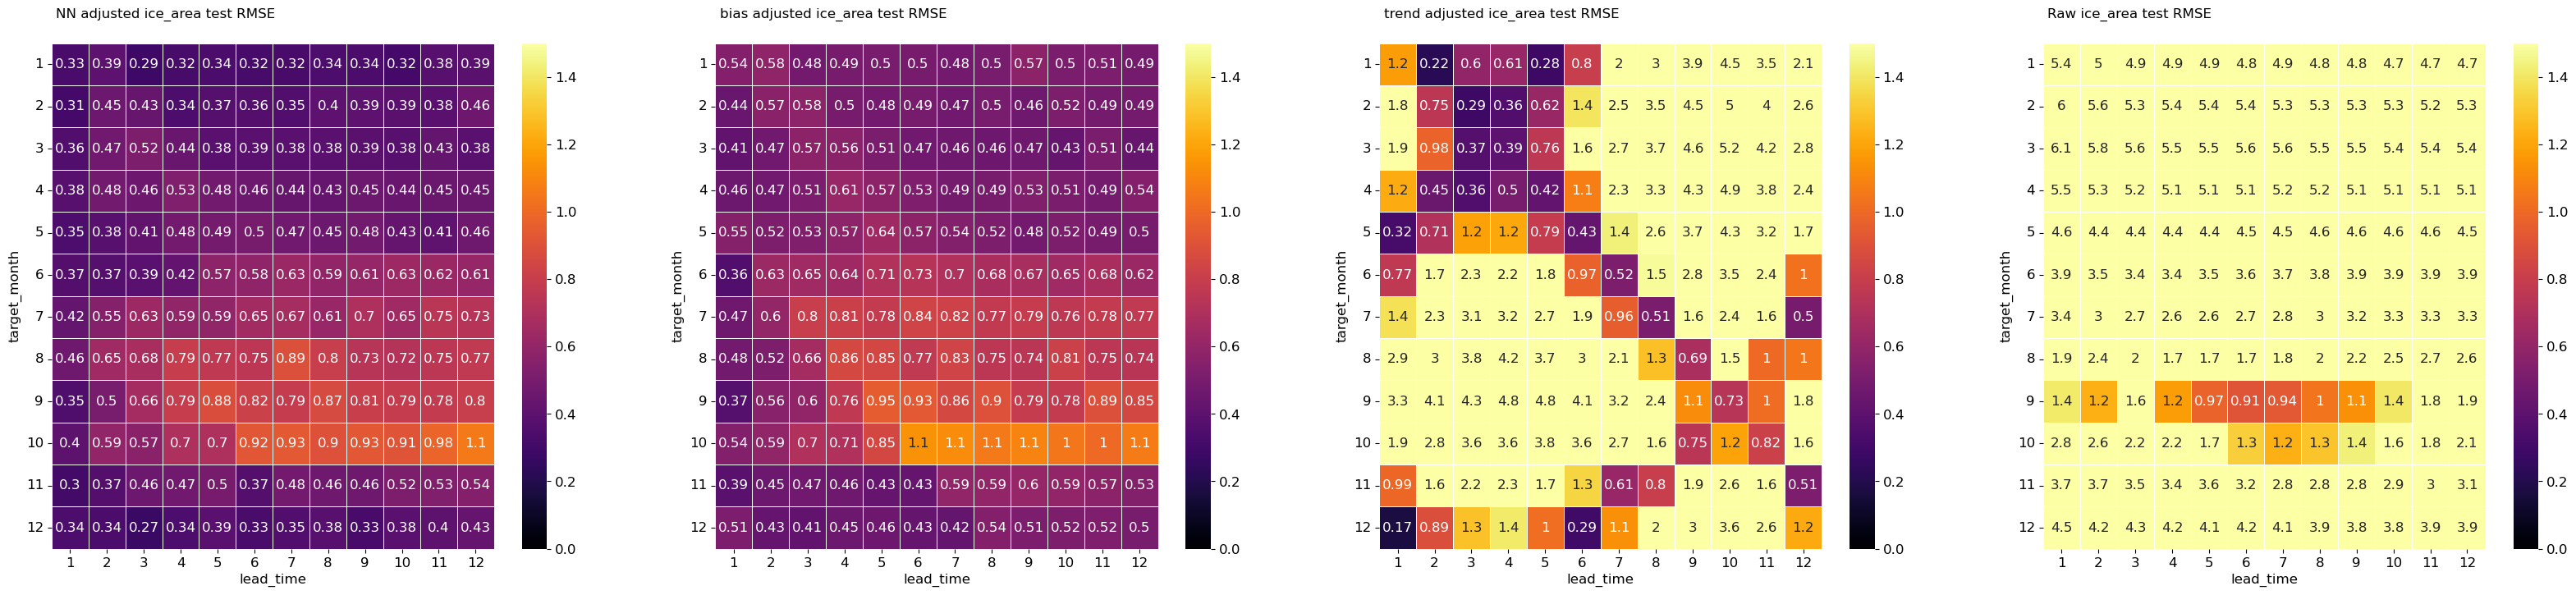

In [17]:
METRIC = 'RMSE'

plot_heat_maps(adj_data_list, lead_times = lead_times,mode = 'ice_area', metric = METRIC, NPSProj=NPSProj)


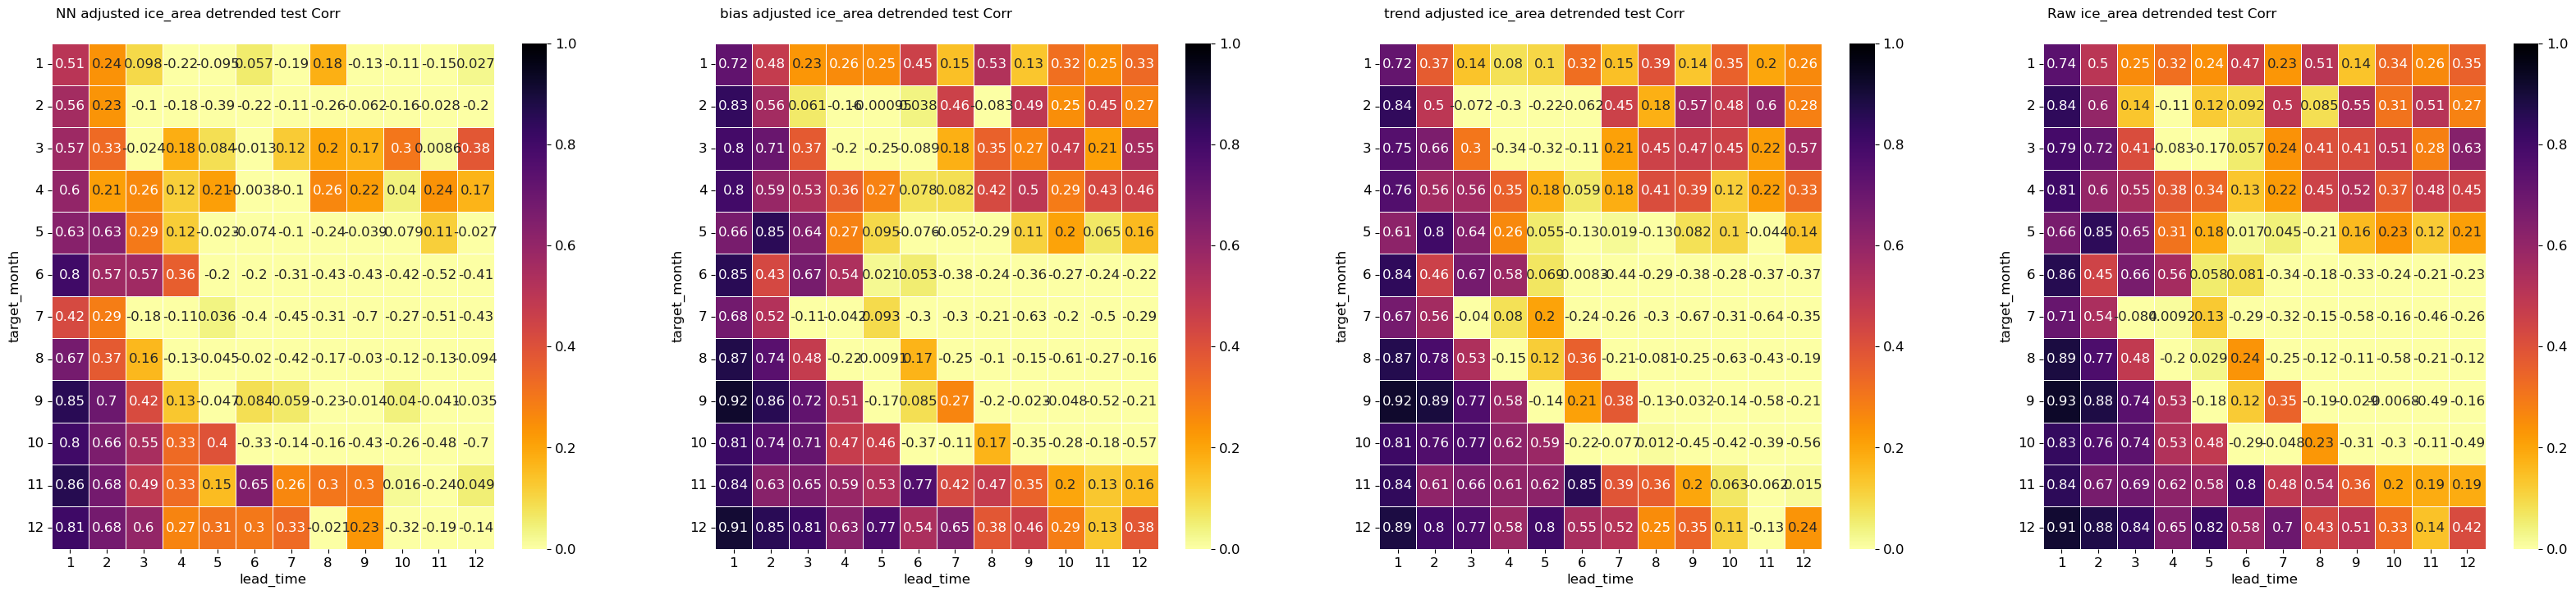

In [18]:
METRIC = 'Corr'

plot_heat_maps(adj_data_list, lead_times = lead_times,mode = 'ice_area', metric = METRIC, detrend=True, NPSProj=NPSProj)


/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/miniconda3/envs/rsaenv_neurips/lib/python3.10/site-packages/dask/array/core.py:4601: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/miniconda3/envs/rsaenv_neurips/lib/python3.10/site-packages/dask/array/core.py:4601: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/miniconda3/envs/rsaenv_neurips/lib/python3.10/site-packages/dask/array/core.py:4601: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/miniconda3/envs/rsaenv_neurips/lib/python3.10/site-packages/dask/array/core.py:4601: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/miniconda3/envs/rsaenv_neurips/lib/python3.10/site-packages/dask/a

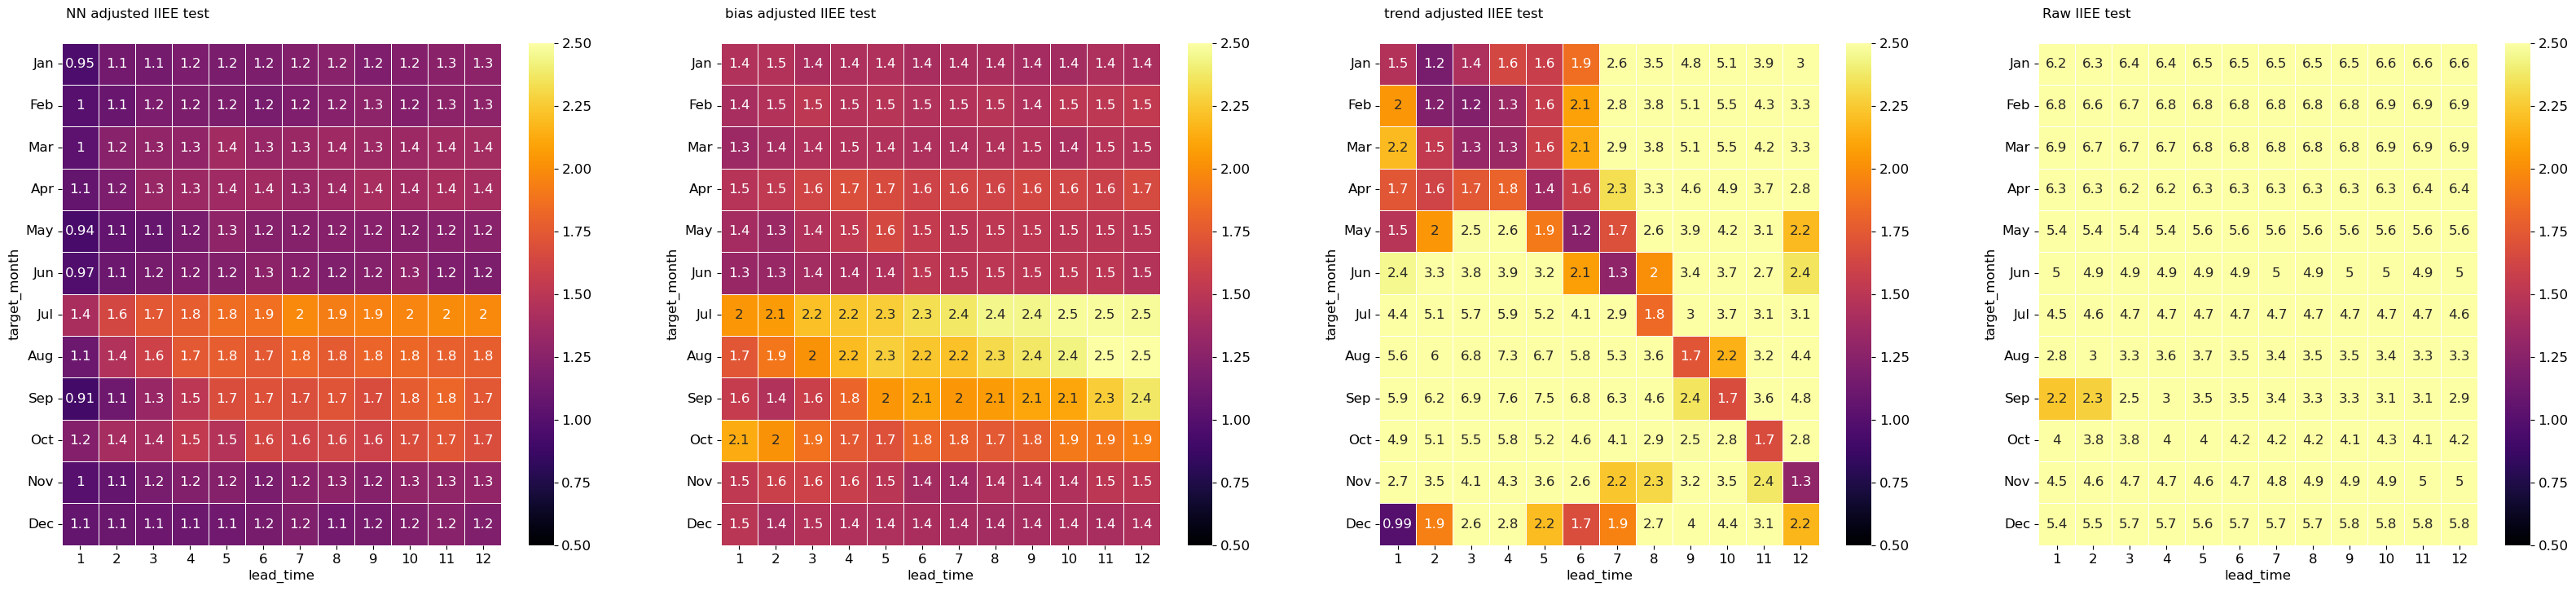

In [19]:
plot_IIEE_heat_maps(adj_data_list, lead_times = lead_times, NPSProj=NPSProj)

In [ ]:
METRIC = 'RMSE'

plot_heat_maps(['NN','Deb','Det', 'Raw'],mode = 'grid_wise', metric = METRIC)


In [ ]:
METRIC = 'Corr'

plot_heat_maps(['NN','Deb','Det', 'Raw'],mode = 'grid_wise', metric = METRIC, detrend=True)


## South

In [155]:
model = 'Autoencoder'
run_set = 4
results = 'N15_M12_v1_North_arch2_batch100_e20_LNone_bias_adj'

out_dir = f'/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/output/SI/Full/results/{model}/run_set_{run_set}/{results}'


nn = xr.open_mfdataset(str(Path(out_dir, "*.nc")), combine= 'nested', concat_dim='time')['nn_adjusted']
ds_model = ds_in.where(ds_in <=1 , 0).sel(time = nn.time)
obs = xr.open_dataset(data_dir_obs)['SICN']


data_dicts = { 'Deb' : deb, 'Det' : det, 'NN' :nn}

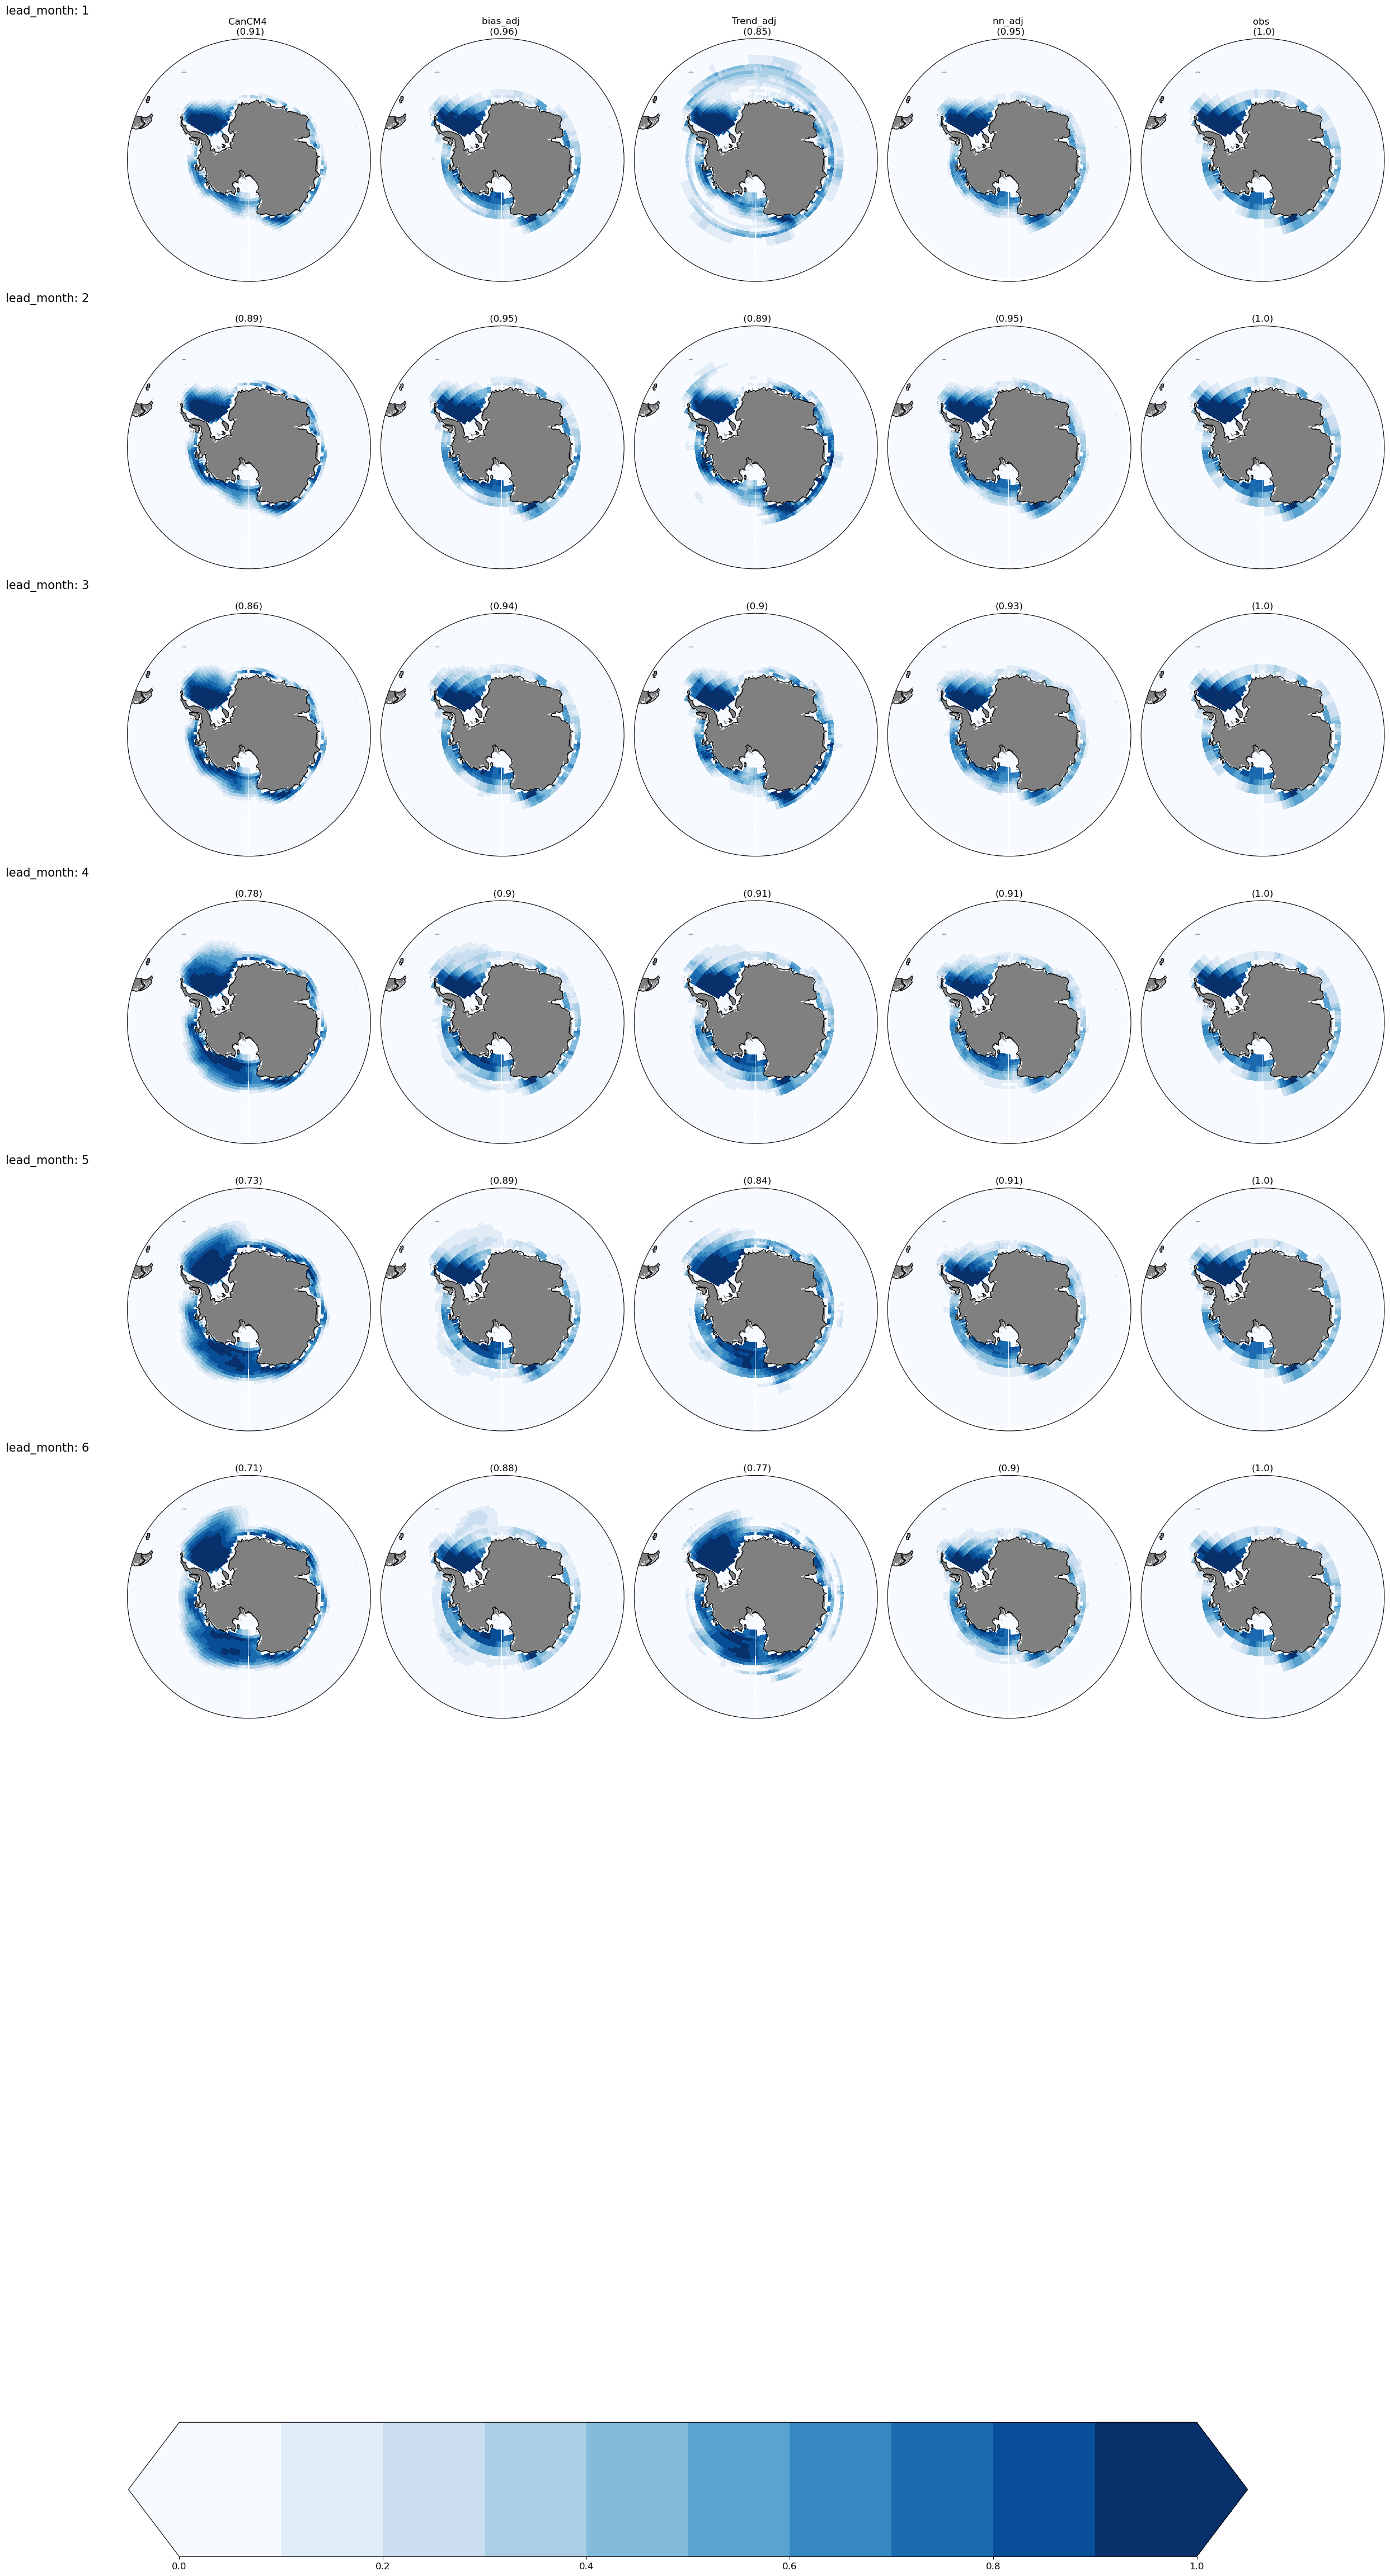

In [156]:
lead_months = 6
target_month  = 3 

adj = extract_tragte_month(nn,lead_months,target_month)
bias_adj = extract_tragte_month(deb,lead_months,target_month)
trend_adj = extract_tragte_month(det,lead_months,target_month)
model = extract_tragte_month(ds_model,lead_months,target_month)
observation = obs.sel(time = adj.time)

call_to_plot(6, Antarctic= True )

In [ ]:
ice_sum_plot(target_month , lead_months , ['NN', 'Deb', 'Det'], 'South')


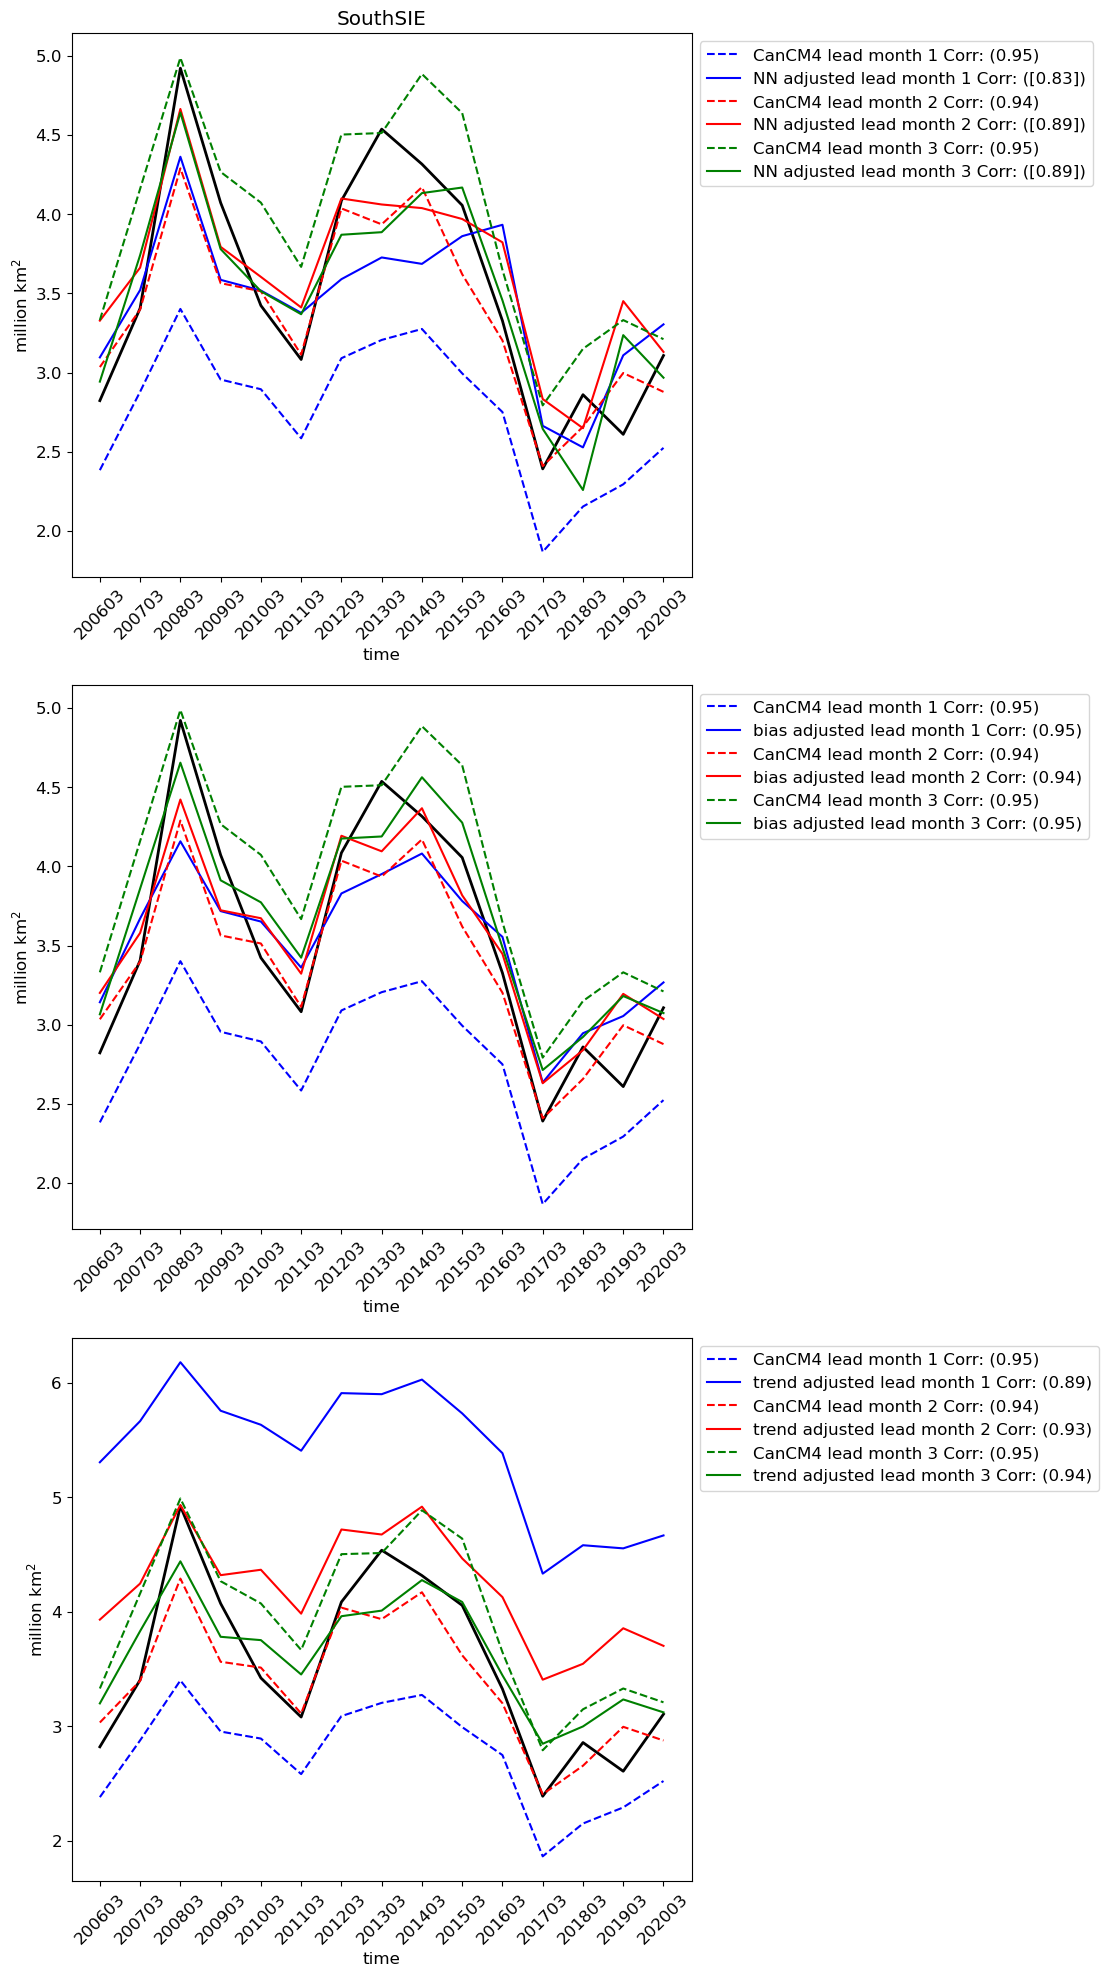

In [157]:
ice_extent_plot(target_month , 3, ['NN', 'Deb',  'Det'], 'South', metric='Corr')


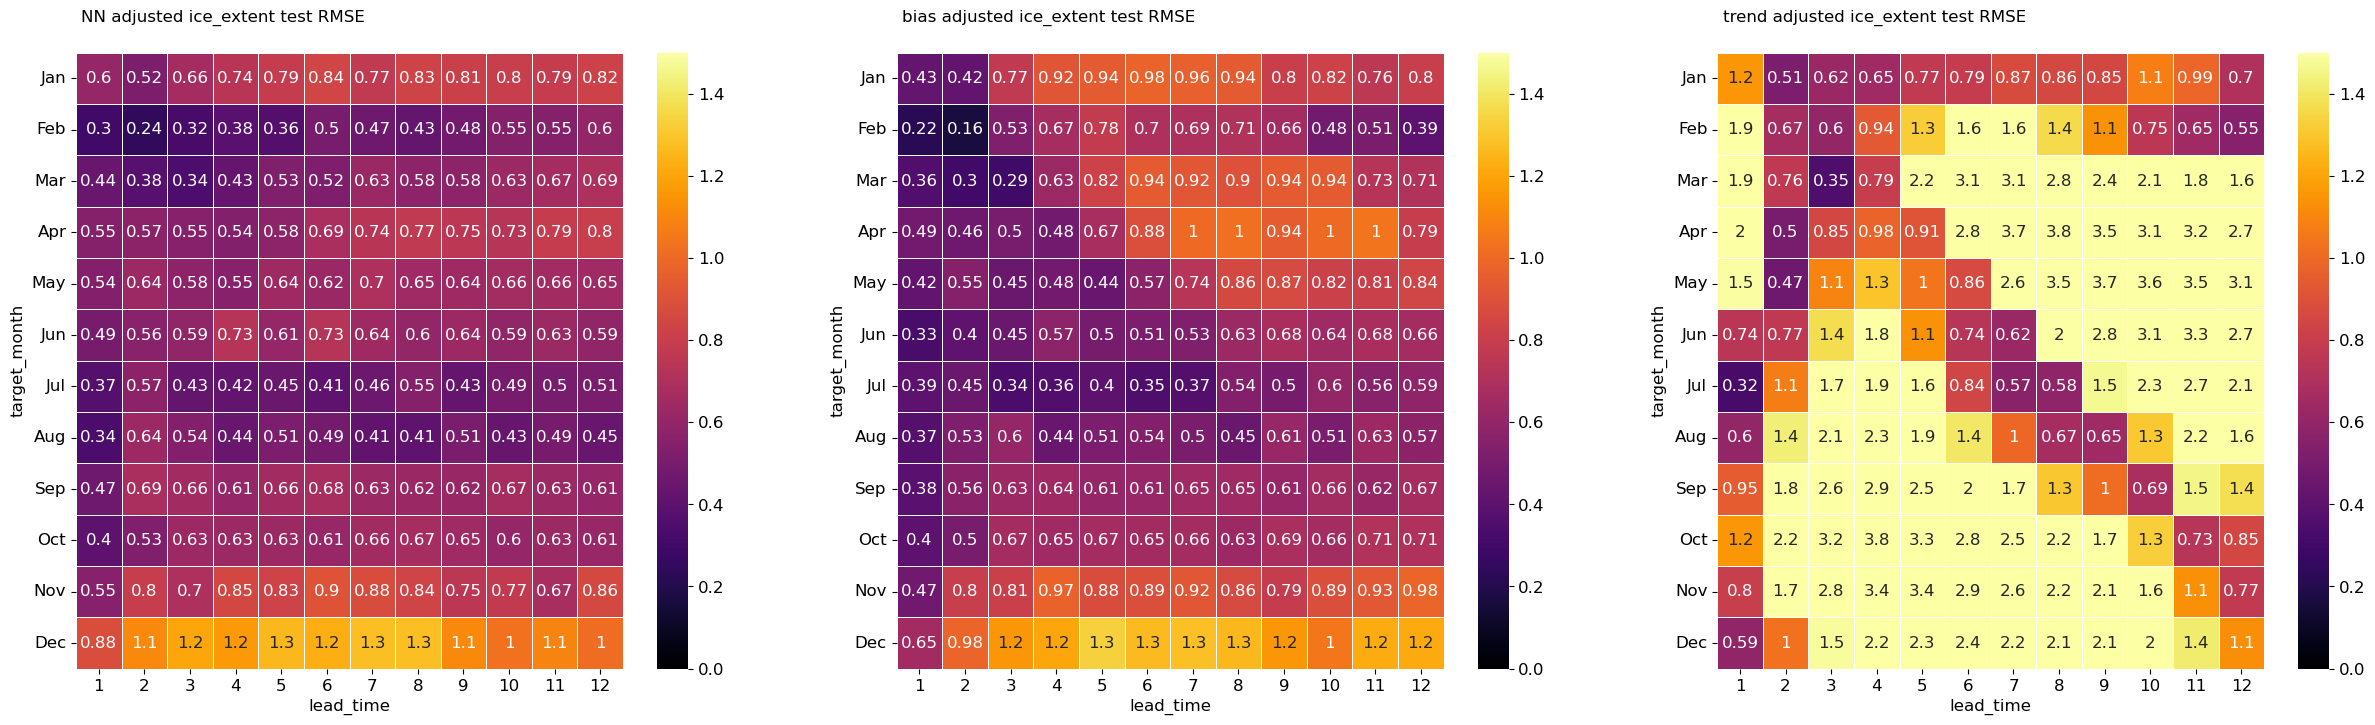

In [158]:
METRIC = 'RMSE'

plot_heat_maps(['NN','Deb','Det'], metric = METRIC, pole = 'South')

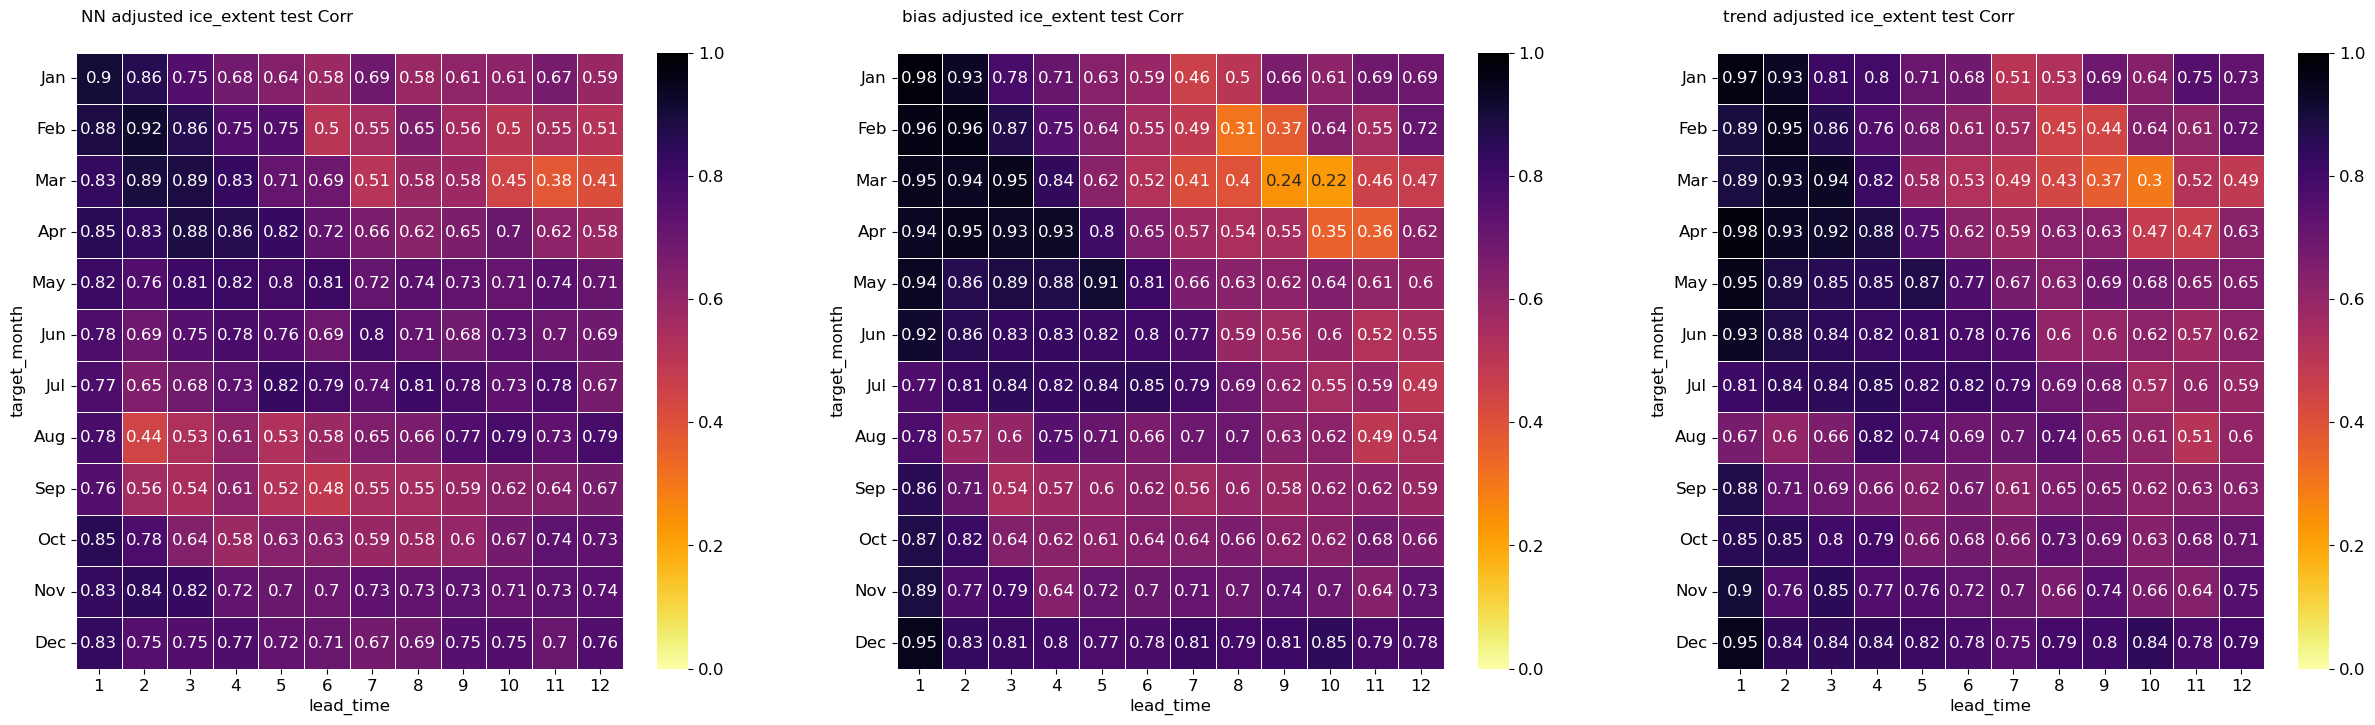

In [159]:
METRIC = 'Corr'

plot_heat_maps(['NN','Deb','Det'], metric = METRIC, pole = 'South')